In [81]:
import os

import numpy as np
import pysindy as ps

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import utils
torch.set_default_dtype(torch.float64)

In [82]:
def rk4(func, tk, yk, dt):
    
    f1 = func(tk, yk)
    f2 = func(tk + dt / 2, yk + (f1 * (dt / 2)))
    f3 = func(tk + dt / 2, yk + (f2 * (dt / 2)))
    f4 = func(tk + dt, yk + (f3 * dt))

    return yk + (dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)

In [83]:
dataset_folder = "D:/Robotics/neural-fly-main/neural-fly-main/data/experiment"

features1 = ['v']
RawData1 = utils.load_data(dataset_folder)
Data1 = utils.format_data(RawData1, features=features1)

v2 = torch.zeros((2511,3)) #first input feature
for row in range(len(v2)):
    for column in range(3):
        v2[row][column] = Data1[22][0][row][column]
v2.dtype

torch.float64

In [84]:
v2[0]

tensor([-0.1817, -0.0068, -0.1428])

In [85]:
v = torch.zeros((2511,3)) #first input feature
for row in range(len(v)):
    for column in range(3):
        v[row][column] = Data1[21][0][row][column]
        
v[0]

tensor([-0.0448, -0.0167, -0.0341])

In [86]:
v3 = torch.zeros((2511,3)) #first input feature
for row in range(len(v)):
    for column in range(3):
        v3[row][column] = Data1[24][0][row][column]

In [87]:
features2 = ['T_sp']

Data2 = utils.format_data(RawData1, features=features2)

fu = torch.zeros((2511,3))
for row in range(len(fu)):
    fu[row][2] = Data2[21][0][row][0]
    
R = torch.zeros((2511,3,3))
features3 = ['R']

Data3 = utils.format_data(RawData1, features=features3)

for matrix in range(len(R)):
    for row in range(3):
        for column in range(3):
            R[matrix][row][column] = Data3[21][0][matrix][row][column]
            
Rfu = torch.zeros((2511,3)) #second input feature
for row in range(len(Rfu)):
    Rfu[row] = np.matmul(R[row],fu[row])
Rfu.shape

torch.Size([2511, 3])

In [88]:
fu2 = torch.zeros((2511,3))
for row in range(len(fu)):
    fu2[row][2] = Data2[21][0][row][0]
    
R2 = torch.zeros((2511,3,3))
for matrix in range(len(R2)):
    for row in range(3):
        for column in range(3):
            R2[matrix][row][column] = Data3[21][0][matrix][row][column]
            
Rfu2 = torch.zeros((2511,3)) #second input feature
for row in range(len(Rfu)):
    Rfu2[row] = np.matmul(R2[row],fu2[row])

In [89]:
fu3 = torch.zeros((2511,3))
for row in range(len(fu3)):
    fu3[row][2] = Data2[24][0][row][0]
    
R3 = torch.zeros((2511,3,3))
for matrix in range(len(R3)):
    for row in range(3):
        for column in range(3):
            R3[matrix][row][column] = Data3[24][0][matrix][row][column]
            
Rfu3 = torch.zeros((2511,3)) #second input feature
for row in range(len(Rfu3)):
    Rfu3[row] = np.matmul(R3[row],fu3[row])

In [90]:
acc = torch.zeros((2511,3)) # actual acceleration
for ele in range(2510):
    acc[ele] = (v[ele+1]-v[ele])/0.02
acc[2510] = acc[2509]

In [91]:
acc2 = torch.zeros((2511,3)) # actual acceleration
for ele in range(2510):
    acc2[ele] = (v2[ele+1]-v2[ele])/0.02
acc2[2510] = acc2[2509]

In [92]:
acc3 = torch.zeros((2511,3)) # actual acceleration
for ele in range(2510):
    acc3[ele] = (v3[ele+1]-v3[ele])/0.02
acc3[2510] = acc3[2509]

In [93]:
features4 = ['w']
Data4 = utils.format_data(RawData1, features=features4)

w = torch.zeros((2511,3))
for row in range(len(w)):
    for column in range(3):
        w[row][column] = Data4[21][0][row][column]
w[0].dtype

torch.float64

In [94]:
alpha = torch.zeros((2511,3)) # actual acceleration
for ele in range(2510):
    alpha[ele] = (w[ele+1]-w[ele])/0.02
alpha[2510] = alpha[2509]

In [95]:
features5 = ['pwm']
Data5 = utils.format_data(RawData1, features=features5)

pwm = torch.zeros((2511,4))
for row in range(len(pwm)):
    for column in range(4):
        pwm[row][column] = Data5[21][0][row][column]
pwm[0]

tensor([0.9755, 1.0750, 0.9395, 1.0563])

In [96]:
pwm_sq = torch.square(pwm)
pwm_sq[0]

c_t = 0.1187
c_q = 0.1187
l_arm = 0.5
B = torch.tensor([[c_t, c_t, c_t, c_t],[0, c_t*l_arm, 0, -c_t*l_arm],[-c_t*l_arm, 0, c_t*l_arm, 0],[-c_q, c_q, -c_q, c_q]])
wrentch_transpose = torch.matmul(B,pwm_sq.T)
wrentch = wrentch_transpose.T
wrentch.size()

torch.Size([2511, 4])

In [97]:
# sum_columns_pwm = torch.sum(pwm_sq, dim=1)
# print(sum_columns_pwm[0])
# c_t_col = torch.zeros((2511,1))
# for row in range(len(c_t_col)):
#     c_t_col[row] = fu[row][2]/sum_columns_pwm[row]
# print(torch.mean(c_t_col))

larm_col = torch.zeros((2511,1))
larm_col = c_t*pwm_sq[:,1] - c_t*pwm_sq[:,3]


In [98]:
tau = torch.zeros((2511,3))
for row in range(len(tau)):
    for column in range(3):
        tau[row][column] = wrentch[row][column+1]
        
wrentch[10]

tensor([ 0.4918,  0.0036, -0.0058,  0.0638])

In [99]:
tau[0]

tensor([ 0.0024, -0.0041,  0.0519])

In [100]:
control = torch.cat((Rfu, tau),dim = 1)
v_n_w = torch.cat((v,w),dim = 1)
v_n_w[0]

tensor([-0.0448, -0.0167, -0.0341, -0.0141,  0.0138,  0.0099])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
dt = 0.02

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.gelu1 = nn.GELU()
        self.fc2 = nn.Linear(50, 100)
        self.gelu2 = nn.GELU()
        self.fc3 = nn.Linear(100, 50)
        self.gelu3 = nn.GELU()
        self.fc4 = nn.Linear(50, 1)

    def forward(self, x):
        
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(x).float()
        if len(x.shape) != 0:
            x = x.unsqueeze(0).transpose(0, 1)
        #print(x_tensor.shape)
        #print('step_0')
        if len(x.shape) == 0:
            x = x.unsqueeze(0)
        x = self.fc1(x)
        #print('step_1')
        x = self.gelu1(x)
        x = self.fc2(x)
        #print('step_2')
        x = self.gelu2(x)
        x = self.fc3(x)
        #print('step_3')
        x = self.gelu3(x)
        x = self.fc4(x)
        
        temp = x.detach().numpy()
        
        temp = np.squeeze(temp)
        #print(x.shape)
        return temp

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)

model1 = RegressionNN()
model1.apply(init_weights)

model2 = RegressionNN()
model2.apply(init_weights)

model3 = RegressionNN()
model3.apply(init_weights)

model4 = RegressionNN()
model4.apply(init_weights)

model5 = RegressionNN()
model5.apply(init_weights)

v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test = train_test_split(v, Rfu, acc, test_size=0.33,shuffle=False)

dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.05, alpha=.2)

library_functions = [
    lambda x : model1(x),
    lambda x : model2(x),
    lambda x : model3(x),
    lambda x : model4(x),
    lambda x : model5(x)
]
library_function_names = [
    lambda x : '*model1(' + x + ')',
    lambda x : '*model2(' + x + ')',
    lambda x : '*model3(' + x + ')',
    lambda x : '*model4(' + x + ')',
    lambda x : '*model5(' + x + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)


#model.print()
num_iterations = 1682
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.009)
optimizer2 = torch.optim.Adam(model1.parameters(), lr=0.05)
optimizer3 = torch.optim.Adam(model1.parameters(), lr=0.007)
optimizer4 = torch.optim.Adam(model1.parameters(), lr=0.03)
optimizer5 = torch.optim.Adam(model1.parameters(), lr=0.01)

v_train = torch.Tensor(v_train)
Rfu_train = torch.Tensor(Rfu_train)
acc_train = torch.Tensor(acc_train)
error_cumulative = 0
error_history = []
epochs = 10
 
    
    
for i in range(num_iterations):
    
    
    model1.train()
    model2.train()
    model3.train()
    model4.train()
    model5.train() 

    v_train.requires_grad_()
    Rfu_train.requires_grad_()
    model = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
    model.fit(v_train.detach().numpy(), u=Rfu_train.detach().numpy(), t=dt)
    coefficients = torch.Tensor(model.coefficients())

    accel_pred = torch.zeros(3)

    equations = []
    index = i

    coefficients = model.coefficients()
    num_equations = len(coefficients)


    for equation_coeffs in coefficients:
        equation = ''
        for i, coeff in enumerate(equation_coeffs):
            if coeff != 0:
                model_num = (i // 6) + 1
                variable_type = 'v_train' if i % 6 < 3 else 'Rfu_train'
                variable_num = i % 3
                term = f"{coeff:.3f} *model{model_num}({variable_type}[{index}][{variable_num}])"
                equation += term + ' + '

        equation = equation[:-3]  # Remove the extra ' + ' at the end
        equations.append(equation)

    accel_pred[0] = eval(equations[0])
    accel_pred[1] = eval(equations[1])
    accel_pred[2] = eval(equations[2])
    #v_train.requires_grad = True
    #Rfu_train.requires_grad = True
    accel_pred.requires_grad = True

    error = (torch.sum(acc_train[i] - accel_pred))**2

    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    optimizer4.zero_grad()
    optimizer5.zero_grad()

    error.backward()

    optimizer1.step()
    optimizer2.step()
    optimizer3.step()
    optimizer4.step()
    optimizer5.step()
    
    print(error)

    error_temp  = error
    error_history.append(error_temp.detach().numpy())
    
    if (error < 0.0001):
        break

    #print(error_cumulative)

    i+=1 


In [ ]:
plt.plot(range(len(error_history)), error_history)
plt.xlabel('iterations')
plt.ylabel('Error')
plt.title('Error versus iterations')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
dt = 0.02

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.gelu1 = nn.GELU()
        self.fc2 = nn.Linear(50, 100)
        self.gelu2 = nn.GELU()
        self.fc3 = nn.Linear(100, 50)
        self.gelu3 = nn.GELU()
        self.fc4 = nn.Linear(50, 1)

    def forward(self, x):
        
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(x).float()
        if len(x.shape) != 0:
            x = x.unsqueeze(0).transpose(0, 1)
        #print(x_tensor.shape)
        #print('step_0')
        if len(x.shape) == 0:
            x = x.unsqueeze(0)
        x = self.fc1(x)
        #print('step_1')
        x = self.gelu1(x)
        x = self.fc2(x)
        #print('step_2')
        x = self.gelu2(x)
        x = self.fc3(x)
        #print('step_3')
        x = self.gelu3(x)
        x = self.fc4(x)
        
        temp = x.detach().numpy()
        
        temp = np.squeeze(temp)
        #print(x.shape)
        return temp

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)

model1 = RegressionNN()
model1.apply(init_weights)

model2 = RegressionNN()
model2.apply(init_weights)

model3 = RegressionNN()
model3.apply(init_weights)

model4 = RegressionNN()
model4.apply(init_weights)

model5 = RegressionNN()
model5.apply(init_weights)

v_train, v_test, Rfu_train, Rfu_test, acc_train, acc_test = train_test_split(v, Rfu, acc, test_size=0.33,shuffle=False)

dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.05, alpha=.2)

library_functions = [
    lambda x : model1(x),
    lambda x : model2(x),
    lambda x : model3(x),
    lambda x : model4(x),
    lambda x : model5(x)
]
library_function_names = [
    lambda x : '*model1(' + x + ')',
    lambda x : '*model2(' + x + ')',
    lambda x : '*model3(' + x + ')',
    lambda x : '*model4(' + x + ')',
    lambda x : '*model5(' + x + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

#model.print()
num_iterations = 10
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.009)
optimizer2 = torch.optim.Adam(model1.parameters(), lr=0.05)
optimizer3 = torch.optim.Adam(model1.parameters(), lr=0.007)
optimizer4 = torch.optim.Adam(model1.parameters(), lr=0.03)
optimizer5 = torch.optim.Adam(model1.parameters(), lr=0.01)

v_train = torch.Tensor(v_train)
Rfu_train = torch.Tensor(Rfu_train)
acc_train = torch.Tensor(acc_train)
error_cumulative = 0
error_history = []
epochs = 10
 
for j in range(epochs):
    
    model1.train()
    model2.train()
    model3.train()
    model4.train()
    model5.train() 

    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    optimizer4.zero_grad()
    optimizer5.zero_grad()
    
    c_err = 0
    
    for i in range(num_iterations):

        v_train.requires_grad_()
        Rfu_train.requires_grad_()
        model = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
        model.fit(v_train.detach().numpy(), u=Rfu_train.detach().numpy(), t=dt)
        coefficients = torch.Tensor(model.coefficients())

        accel_pred = torch.zeros(3)

        equations = []
        index = i

        coefficients = model.coefficients()
        num_equations = len(coefficients)

        for equation_coeffs in coefficients:
            equation = ''
            for i, coeff in enumerate(equation_coeffs):
                if coeff != 0:
                    model_num = (i // 6) + 1
                    variable_type = 'v_train' if i % 6 < 3 else 'Rfu_train'
                    variable_num = i % 3
                    term = f"{coeff:.3f} *model{model_num}({variable_type}[{index}][{variable_num}])"
                    equation += term + ' + '

            equation = equation[:-3]  # Remove the extra ' + ' at the end
            equations.append(equation)

        accel_pred[0] = eval(equations[0])
        accel_pred[1] = eval(equations[1])
        accel_pred[2] = eval(equations[2])
        #v_train.requires_grad = True
        #Rfu_train.requires_grad = True
        accel_pred.requires_grad = True

        error = (torch.sum(acc_train[i] - accel_pred))**2

        error.backward()

        #print('error')
        #print(error)
        error_temp  = error
        c_err += error_temp

        #print(error_cumulative)

        i+=1

    optimizer1.step()
    optimizer2.step()
    optimizer3.step()
    optimizer4.step()
    optimizer5.step()
    
    c_err = c_err/num_iterations
    print('c_err')
    print(c_err)
    
    error_history.append(c_err.detach().numpy())


In [ ]:
print(error)

In [ ]:
accel_predicted = model.predict(v_test, u = Rfu_test)
test_error1 = (np.sum((accel_predicted - acc_test)**2))/len(accel_predicted)

In [ ]:
print(test_error1)

In [ ]:
accel_pred2 = model.predict(v2,u=Rfu2)

In [ ]:
# Calculate the residuals by subtracting the predicted values from the actual values
residuals2 = np.array(acc2) - np.array(accel_pred2)

# Plot the residuals against the predicted values
plt.scatter(accel_pred2, residuals2)

In [ ]:
 accel_pred3 = model.predict(v3,u=Rfu3)

In [ ]:
# Calculate the residuals by subtracting the predicted values from the actual values
residuals3= np.array(acc3) - np.array(accel_pred3)

# Plot the residuals against the predicted values
plt.scatter(accel_pred3, residuals3)

In [ ]:
model.equations()

In [ ]:
equations = []

coefficients = model.coefficients()
num_equations = len(coefficients)

for equation_coeffs in coefficients:
    equation = ''
    for i, coeff in enumerate(equation_coeffs):
        if coeff != 0:
            model_num = (i // 6) + 1
            variable_type = 'x' if i % 6 < 3 else 'u'
            variable_num = i % 3
            term = f"{coeff:.3f} *model{model_num}({variable_type}{variable_num})"
            equation += term + ' + '

    equation = equation[:-3]  # Remove the extra ' + ' at the end
    equations.append(equation)

print(equations)

In [ ]:
equations = []
index = 1

coefficients = model.coefficients()
num_equations = len(coefficients)

for equation_coeffs in coefficients:
    equation = ''
    for i, coeff in enumerate(equation_coeffs):
        if coeff != 0:
            model_num = (i // 6) + 1
            variable_type = 'v_train' if i % 6 < 3 else 'Rfu_train'
            variable_num = i % 3
            term = f"{coeff:.3f} *model{model_num}({variable_type}[{index}][{variable_num}])"
            equation += term + ' + '

    equation = equation[:-3]  # Remove the extra ' + ' at the end
    equations.append(equation)

In [ ]:
accel_pred = eval(equations[0])

## Residue Learning

## SINDy basis fn : sin(x)

In [83]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.3, alpha=.3)

library_functions = [
    lambda x : np.sin(x)
]
library_function_names = [
    lambda x : '*np.sin(' + x + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model.fit(v, u=Rfu, t=dt)
model.print()

(x0)' = -0.338 *np.sin(x0) + -2.240 *np.sin(x1) + 21.511 *np.sin(u0) + -2.645 *np.sin(u2)
(x1)' = 1.661 *np.sin(u1)
(x2)' = -22.619 *np.sin(x1) + -1.947 *np.sin(u0) + -54.819 *np.sin(u1) + 2.009 *np.sin(u2)


In [84]:
acc_pred = model.predict(v,u=Rfu)

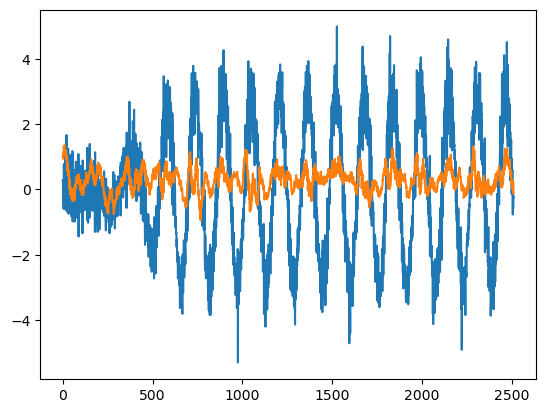

In [89]:
plt.plot(acc[:,2])
plt.plot(acc_pred[:,2])

In [90]:
residual_acc = acc - acc_pred

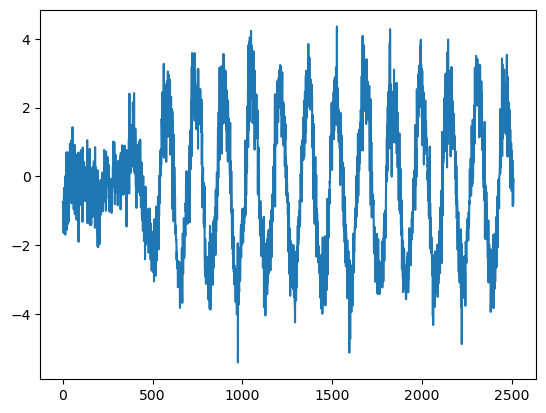

In [91]:
plt.plot(residual_acc[:,2])

In [29]:
error_sindy = mean_squared_error(acc,acc_pred)
error_sindy

1.2869770656799755

In [31]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(256, 79)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(79, 48)
        self.relu8 = nn.ReLU()
        self.linear9 = nn.Linear(48, output_size)
    
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        out = self.relu6(out)
        out = self.linear7(out)
        out = self.relu7(out)
        out = self.linear8(out)
        out = self.relu8(out)
        out = self.linear9(out)
        return out

# Define the training process
model = LinearRegression(6, 3)  # input_size and output_size should be determined based on your data
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=2)

loss_history = []
num_epochs = 500
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        accel_i = torch.Tensor(residual_acc[i]).view(1, -1)
        accel_pred_i = model(v_i, Rfu_i)

        loss_i = criterion(accel_pred_i, accel_i)
        loss_i.backward()
        loss += loss_i.item()

        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_history.append(loss)
    
    scheduler.step(loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/500], Loss: 1.2642
Epoch [20/500], Loss: 1.1575
Epoch [30/500], Loss: 0.9760
Epoch [40/500], Loss: 0.5817
Epoch [50/500], Loss: 0.4997
Epoch [60/500], Loss: 0.4440
Epoch [70/500], Loss: 0.4149
Epoch [80/500], Loss: 0.4021
Epoch [90/500], Loss: 0.3930
Epoch [100/500], Loss: 0.3861
Epoch [110/500], Loss: 0.3793
Epoch [120/500], Loss: 0.3719
Epoch [130/500], Loss: 0.3617
Epoch [140/500], Loss: 0.3417
Epoch [150/500], Loss: 0.3008
Epoch [160/500], Loss: 0.2447
Epoch [170/500], Loss: 0.2173
Epoch [180/500], Loss: 0.2052
Epoch [190/500], Loss: 0.1976
Epoch [200/500], Loss: 0.1913
Epoch [210/500], Loss: 0.1893
Epoch [220/500], Loss: 0.1861
Epoch [230/500], Loss: 0.1839
Epoch [240/500], Loss: 0.1818
Epoch [250/500], Loss: 0.1802
Epoch [260/500], Loss: 0.1790
Epoch [270/500], Loss: 0.1779
Epoch [280/500], Loss: 0.1770
Epoch [290/500], Loss: 0.1762
Epoch [300/500], Loss: 0.1754
Epoch [310/500], Loss: 0.1746
Epoch [320/500], Loss: 0.1750
Epoch [330/500], Loss: 0.1738
Epoch [340/500], Lo

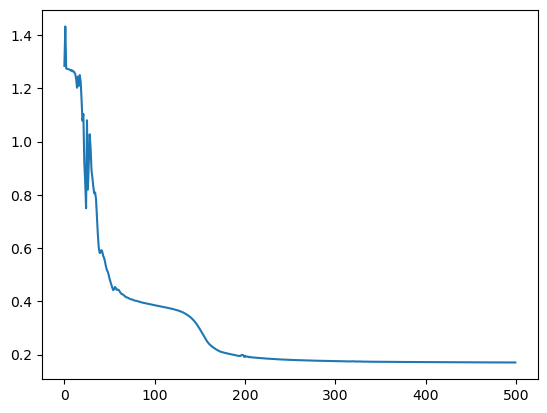

In [33]:
plt.plot(loss_history)

In [36]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    # Add other components if needed
    'optimizer_state_dict': optimizer.state_dict(),
    # 'epoch': epoch,
}
checkpoint_path = "/home/arunabh/Documents/thesis.pth"  # Update with the desired save path
torch.save(checkpoint, checkpoint_path)

In [39]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(256, 79)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(79, 48)
        self.relu8 = nn.ReLU()
        self.linear9 = nn.Linear(48, output_size)
    
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        out = self.relu6(out)
        out = self.linear7(out)
        out = self.relu7(out)
        out = self.linear8(out)
        out = self.relu8(out)
        out = self.linear9(out)
        return out

# Define the training process
model = LinearRegression(6, 3)  # input_size and output_size should be determined based on your data

checkpoint = torch.load("/home/arunabh/Documents/thesis.pth")
model.load_state_dict(checkpoint['model_state_dict'])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=2)

loss_history = []
num_epochs = 500
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        accel_i = torch.Tensor(residual_acc[i]).view(1, -1)
        accel_pred_i = model(v_i, Rfu_i)

        loss_i = criterion(accel_pred_i, accel_i)
        loss_i.backward()
        loss += loss_i.item()

        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_history.append(loss)
    
    scheduler.step(loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/500], Loss: 0.1703
Epoch [20/500], Loss: 0.1702
Epoch [30/500], Loss: 0.1701
Epoch [40/500], Loss: 0.1700
Epoch [50/500], Loss: 0.1700
Epoch [60/500], Loss: 0.1699
Epoch [70/500], Loss: 0.1698
Epoch [80/500], Loss: 0.1698
Epoch [90/500], Loss: 0.1697
Epoch [100/500], Loss: 0.1696
Epoch [110/500], Loss: 0.1695
Epoch [120/500], Loss: 0.1695
Epoch [130/500], Loss: 0.1694
Epoch [140/500], Loss: 0.1693
Epoch [150/500], Loss: 0.1693
Epoch [160/500], Loss: 0.1692
Epoch [170/500], Loss: 0.1692
Epoch [180/500], Loss: 0.1692
Epoch [190/500], Loss: 0.1692
Epoch [200/500], Loss: 0.1692
Epoch [210/500], Loss: 0.1692
Epoch [220/500], Loss: 0.1692
Epoch [230/500], Loss: 0.1692
Epoch [240/500], Loss: 0.1692
Epoch [250/500], Loss: 0.1692
Epoch [260/500], Loss: 0.1692
Epoch [270/500], Loss: 0.1692
Epoch [280/500], Loss: 0.1692
Epoch [290/500], Loss: 0.1692
Epoch [300/500], Loss: 0.1692
Epoch [310/500], Loss: 0.1692
Epoch [320/500], Loss: 0.1692
Epoch [330/500], Loss: 0.1692
Epoch [340/500], Lo

KeyboardInterrupt: 

In [67]:
accel_pred_nn = torch.zeros((2511, 3))
for i in range(len(v)):
    test_v_i = torch.Tensor(v[i]).view(1, -1)
    test_Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
    accel_pred_i = model(test_v_i, test_Rfu_i)
    accel_pred_nn[i] = accel_pred_i
accel_pred_nn = accel_pred_nn.detach().numpy()

In [75]:
acc1_pred = accel_pred_nn + acc_pred

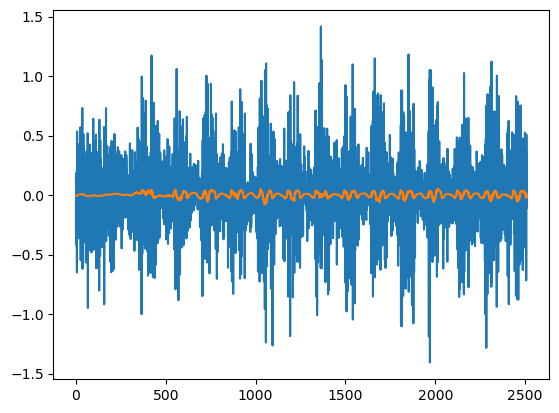

In [319]:
plt.plot(acc[:,1])
plt.plot(acc1_pred[:,1])

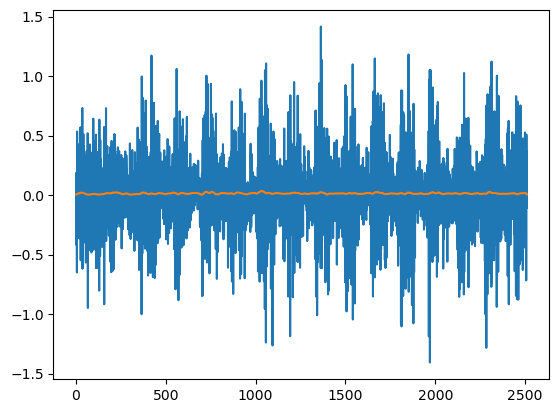

In [320]:
plt.plot(acc[:,1])
plt.plot(acc_pred[:,1])

In [321]:
mean_squared_error(acc_pred1,acc)

0.16921159297280716

## SINDy basis function sin(x) and cos(x)

In [42]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.3, alpha=.3)

library_functions = [
    lambda x : np.sin(x),
    lambda x : np.cos(x)
]
library_function_names = [
    lambda x : '*np.sin(' + x + ')',
    lambda x : '*np.cos(' + x + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model2 = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model2.fit(v, u=Rfu, t=dt)
model2.print()

(x0)' = -0.339 *np.sin(x0) + -0.282 *np.sin(x1) + 21.584 *np.sin(u0) + 3.789 *np.sin(u1) + -1.249 *np.cos(u0)
(x1)' = 1.661 *np.sin(u1)
(x2)' = 1.957 *np.sin(x1) + 14.783 *np.sin(u1) + 23.111 *np.sin(u2) + 0.875 *np.cos(x0) + -12.430 *np.cos(u2)


In [43]:
acc_pred2 = model2.predict(v,u=Rfu)

In [44]:
residual_acc2 = acc - acc_pred2

In [45]:
error_sindy = mean_squared_error(acc,acc_pred2)
error_sindy

0.17058921514757222

In [47]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(256, 79)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(79, 48)
        self.relu8 = nn.ReLU()
        self.linear9 = nn.Linear(48, output_size)
    
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        out = self.relu6(out)
        out = self.linear7(out)
        out = self.relu7(out)
        out = self.linear8(out)
        out = self.relu8(out)
        out = self.linear9(out)
        return out

# Define the training process
model_2 = LinearRegression(6, 3)  # input_size and output_size should be determined based on your data
criterion = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.006)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=2)

loss_history2 = []
num_epochs = 500
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        accel_i = torch.Tensor(residual_acc2[i]).view(1, -1)
        accel_pred_i = model_2(v_i, Rfu_i)

        loss_i = criterion(accel_pred_i, accel_i)
        loss_i.backward()
        loss += loss_i.item()

        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_history2.append(loss)
    scheduler.step(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/500], Loss: 0.1677
Epoch [20/500], Loss: 0.1646
Epoch [30/500], Loss: 0.1642
Epoch [40/500], Loss: 0.1628
Epoch [50/500], Loss: 0.1611
Epoch [60/500], Loss: 0.1600
Epoch [70/500], Loss: 0.1595
Epoch [80/500], Loss: 0.1588
Epoch [90/500], Loss: 0.1584
Epoch [100/500], Loss: 0.1580
Epoch [110/500], Loss: 0.1577
Epoch [120/500], Loss: 0.1574
Epoch [130/500], Loss: 0.1570
Epoch [140/500], Loss: 0.1566
Epoch [150/500], Loss: 0.1563
Epoch [160/500], Loss: 0.1561
Epoch [170/500], Loss: 0.1554
Epoch [180/500], Loss: 0.1551
Epoch [190/500], Loss: 0.1544
Epoch [200/500], Loss: 0.1539
Epoch [210/500], Loss: 0.1535
Epoch [220/500], Loss: 0.1523
Epoch [230/500], Loss: 0.1518
Epoch [240/500], Loss: 0.1513
Epoch [250/500], Loss: 0.1509
Epoch [260/500], Loss: 0.1505
Epoch [270/500], Loss: 0.1503
Epoch [280/500], Loss: 0.1500
Epoch [290/500], Loss: 0.1498
Epoch [300/500], Loss: 0.1496
Epoch [310/500], Loss: 0.1494
Epoch [320/500], Loss: 0.1492
Epoch [330/500], Loss: 0.1489
Epoch [340/500], Lo

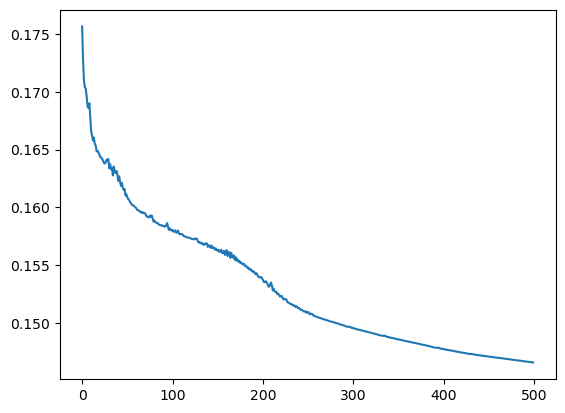

In [48]:
plt.plot(loss_history2)

In [50]:
checkpoint_2 = {
    'model_state_dict': model_2.state_dict(),
    # Add other components if needed
    'optimizer_state_dict': optimizer.state_dict(),
    # 'epoch': epoch,
}
checkpoint_path2 = "/home/arunabh/Documents/thesis2.pth"  # Update with the desired save path
torch.save(checkpoint_2, checkpoint_path2)

In [51]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(256, 79)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(79, 48)
        self.relu8 = nn.ReLU()
        self.linear9 = nn.Linear(48, output_size)
    
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        out = self.relu6(out)
        out = self.linear7(out)
        out = self.relu7(out)
        out = self.linear8(out)
        out = self.relu8(out)
        out = self.linear9(out)
        return out

# Define the training process
model_2a = LinearRegression(6, 3)

checkpoint_2 = torch.load("/home/arunabh/Documents/thesis2.pth")
model_2a.load_state_dict(checkpoint_2['model_state_dict'])

criterion = nn.MSELoss()
optimizer = optim.Adam(model_2a.parameters(), lr=0.006)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=2)
optimizer.load_state_dict(checkpoint_2['optimizer_state_dict'])


loss_history2a = []
num_epochs = 500
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        accel_i = torch.Tensor(residual_acc2[i]).view(1, -1)
        accel_pred_i = model_2a(v_i, Rfu_i)

        loss_i = criterion(accel_pred_i, accel_i)
        loss_i.backward()
        loss += loss_i.item()

        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_history2a.append(loss)
    scheduler.step(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/500], Loss: 0.1465
Epoch [20/500], Loss: 0.1464
Epoch [30/500], Loss: 0.1463
Epoch [40/500], Loss: 0.1462
Epoch [50/500], Loss: 0.1461
Epoch [60/500], Loss: 0.1460
Epoch [70/500], Loss: 0.1459
Epoch [80/500], Loss: 0.1458
Epoch [90/500], Loss: 0.1457
Epoch [100/500], Loss: 0.1457
Epoch [110/500], Loss: 0.1456
Epoch [120/500], Loss: 0.1455
Epoch [130/500], Loss: 0.1454
Epoch [140/500], Loss: 0.1453
Epoch [150/500], Loss: 0.1452
Epoch [160/500], Loss: 0.1452
Epoch [170/500], Loss: 0.1451
Epoch [180/500], Loss: 0.1451
Epoch [190/500], Loss: 0.1451
Epoch [200/500], Loss: 0.1451
Epoch [210/500], Loss: 0.1451
Epoch [220/500], Loss: 0.1451
Epoch [230/500], Loss: 0.1451
Epoch [240/500], Loss: 0.1451
Epoch [250/500], Loss: 0.1451
Epoch [260/500], Loss: 0.1451
Epoch [270/500], Loss: 0.1451
Epoch [280/500], Loss: 0.1451
Epoch [290/500], Loss: 0.1451
Epoch [300/500], Loss: 0.1451
Epoch [310/500], Loss: 0.1451
Epoch [320/500], Loss: 0.1451
Epoch [330/500], Loss: 0.1451
Epoch [340/500], Lo

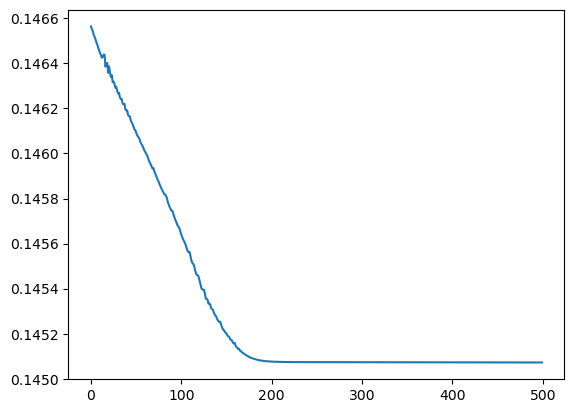

In [52]:
plt.plot(loss_history2a)

In [55]:
accel_pred_nn2 = torch.zeros((2511, 3))
for i in range(len(v)):
    test_v_i = torch.Tensor(v[i]).view(1, -1)
    test_Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
    accel_pred_i = model_2a(test_v_i, test_Rfu_i)
    accel_pred_nn2[i] = accel_pred_i
accel_pred_nn2 = accel_pred_nn2.detach().numpy()

In [56]:
error_post_dnn = mean_squared_error(residual_acc2, accel_pred_nn2)
error_post_dnn

0.14507219009135322

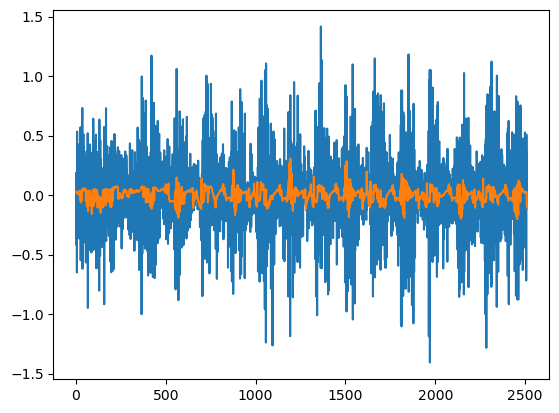

In [327]:
acc2_pred = acc_pred2 + accel_pred_nn2
plt.plot(acc[:,1])
plt.plot(acc2_pred[:,1])

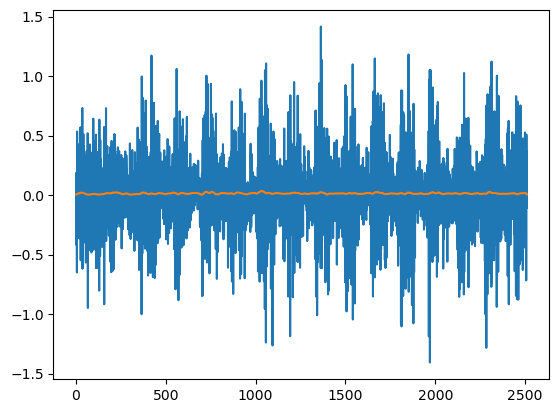

In [325]:
plt.plot(acc[:,1])
plt.plot(acc_pred2[:,1])

In [323]:
mean_squared_error(acc2_pred, acc)

0.14507219009135322

## SINDy basis function sin(x), cos(x) and x*y

In [95]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.3, alpha=.3)

library_functions = [
    lambda x : np.sin(x),
    lambda x : np.cos(x),
    lambda x,y : x*y
]
library_function_names = [
    lambda x : '*np.sin(' + x + ')',
    lambda x : '*np.cos(' + x + ')',
    lambda x,y : x + '*' + y
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model3 = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model3.fit(v, u=Rfu, t=dt)
model3.print()

(x0)' = -0.435 *np.sin(x0) + -0.780 *np.sin(x1) + 9.461 *np.sin(u0) + -1.120 *np.sin(u2) + -0.660 *np.cos(u0) + -1.174 x0*x1 + -1.617 x0*u0 + 0.341 x0*u2 + -1.237 x1*u2 + -1.407 x2*u0 + 0.400 x2*u2 + 23.853 u0*u2
(x1)' = -4.787 *np.sin(u1) + 13.319 u1*u2
(x2)' = -0.043 *np.sin(x0) + 15.625 *np.sin(x1) + 1.921 *np.sin(u0) + 38.570 *np.sin(u1) + 22.728 *np.sin(u2) + 0.683 *np.cos(x0) + -12.035 *np.cos(u2) + 8.065 x0*u0 + 8.591 x0*u1 + -0.717 x0*u2 + -26.206 x1*u2 + -2.788 x2*u0 + -8.741 u0*u2 + -50.470 u1*u2


In [96]:
acc_pred3 = model3.predict(v,u=Rfu)

In [97]:
residual_acc3 = acc - acc_pred3

In [98]:
error_sindy = mean_squared_error(acc,acc_pred3)
error_sindy

0.16290355569415513

In [100]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(256, 79)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(79, 48)
        self.relu8 = nn.ReLU()
        self.linear9 = nn.Linear(48, output_size)
    
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        out = self.relu6(out)
        out = self.linear7(out)
        out = self.relu7(out)
        out = self.linear8(out)
        out = self.relu8(out)
        out = self.linear9(out)
        return out

# Define the training process
model_3 = LinearRegression(6, 3)  # input_size and output_size should be determined based on your data
criterion = nn.MSELoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5)

loss_history3 = []
num_epochs = 500
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        accel_i = torch.Tensor(residual_acc3[i]).view(1, -1)
        accel_pred_i = model_3(v_i, Rfu_i)

        loss_i = criterion(accel_pred_i, accel_i)
        loss_i.backward()
        loss += loss_i.item()

        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_history3.append(loss)
    scheduler.step(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/500], Loss: 0.1630
Epoch [20/500], Loss: 0.1626
Epoch [30/500], Loss: 0.1609
Epoch [40/500], Loss: 0.1604
Epoch [50/500], Loss: 0.1606
Epoch [60/500], Loss: 0.1597
Epoch [70/500], Loss: 0.1595
Epoch [80/500], Loss: 0.1590
Epoch [90/500], Loss: 0.1587
Epoch [100/500], Loss: 0.1582
Epoch [110/500], Loss: 0.1575
Epoch [120/500], Loss: 0.1566
Epoch [130/500], Loss: 0.1595
Epoch [140/500], Loss: 0.1566
Epoch [150/500], Loss: 0.1544
Epoch [160/500], Loss: 0.1536
Epoch [170/500], Loss: 0.1531
Epoch [180/500], Loss: 0.1527
Epoch [190/500], Loss: 0.1523
Epoch [200/500], Loss: 0.1520
Epoch [210/500], Loss: 0.1518
Epoch [220/500], Loss: 0.1512
Epoch [230/500], Loss: 0.1510
Epoch [240/500], Loss: 0.1513
Epoch [250/500], Loss: 0.1504
Epoch [260/500], Loss: 0.1502
Epoch [270/500], Loss: 0.1499
Epoch [280/500], Loss: 0.1498
Epoch [290/500], Loss: 0.1496
Epoch [300/500], Loss: 0.1493
Epoch [310/500], Loss: 0.1494
Epoch [320/500], Loss: 0.1491
Epoch [330/500], Loss: 0.1489
Epoch [340/500], Lo

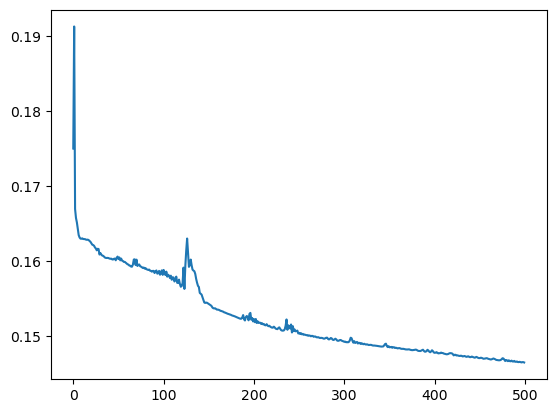

In [328]:
plt.plot(loss_history3)

In [101]:
checkpoint_3 = {
    'model_state_dict': model_3.state_dict(),
    # Add other components if needed
    'optimizer_state_dict': optimizer.state_dict(),
    # 'epoch': epoch,
}
checkpoint_path3 = "/home/arunabh/Documents/thesis3.pth"  # Update with the desired save path
torch.save(checkpoint_3, checkpoint_path3)

In [102]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(256, 79)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(79, 48)
        self.relu8 = nn.ReLU()
        self.linear9 = nn.Linear(48, output_size)
    
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        out = self.relu6(out)
        out = self.linear7(out)
        out = self.relu7(out)
        out = self.linear8(out)
        out = self.relu8(out)
        out = self.linear9(out)
        return out

# Define the training process
model_3a = LinearRegression(6, 3)  # input_size and output_size should be determined based on your data

checkpoint_3 = torch.load("/home/arunabh/Documents/thesis3.pth")
model_3a.load_state_dict(checkpoint_3['model_state_dict'])

criterion = nn.MSELoss()
optimizer = optim.Adam(model_3a.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5)

optimizer.load_state_dict(checkpoint_3['optimizer_state_dict'])

loss_history3a = []
num_epochs = 500
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        accel_i = torch.Tensor(residual_acc3[i]).view(1, -1)
        accel_pred_i = model_3a(v_i, Rfu_i)

        loss_i = criterion(accel_pred_i, accel_i)
        loss_i.backward()
        loss += loss_i.item()

        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_history3a.append(loss)
    scheduler.step(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/500], Loss: 0.1465
Epoch [20/500], Loss: 0.1464
Epoch [30/500], Loss: 0.1463
Epoch [40/500], Loss: 0.1462
Epoch [50/500], Loss: 0.1461
Epoch [60/500], Loss: 0.1460
Epoch [70/500], Loss: 0.1459
Epoch [80/500], Loss: 0.1459
Epoch [90/500], Loss: 0.1458
Epoch [100/500], Loss: 0.1457
Epoch [110/500], Loss: 0.1456
Epoch [120/500], Loss: 0.1456
Epoch [130/500], Loss: 0.1455
Epoch [140/500], Loss: 0.1454
Epoch [150/500], Loss: 0.1454
Epoch [160/500], Loss: 0.1453
Epoch [170/500], Loss: 0.1453
Epoch [180/500], Loss: 0.1452
Epoch [190/500], Loss: 0.1451
Epoch [200/500], Loss: 0.1451
Epoch [210/500], Loss: 0.1450
Epoch [220/500], Loss: 0.1450
Epoch [230/500], Loss: 0.1449
Epoch [240/500], Loss: 0.1449
Epoch [250/500], Loss: 0.1448
Epoch [260/500], Loss: 0.1448
Epoch [270/500], Loss: 0.1448
Epoch [280/500], Loss: 0.1448
Epoch [290/500], Loss: 0.1447
Epoch [300/500], Loss: 0.1447
Epoch [310/500], Loss: 0.1446
Epoch [320/500], Loss: 0.1446
Epoch [330/500], Loss: 0.1446
Epoch [340/500], Lo

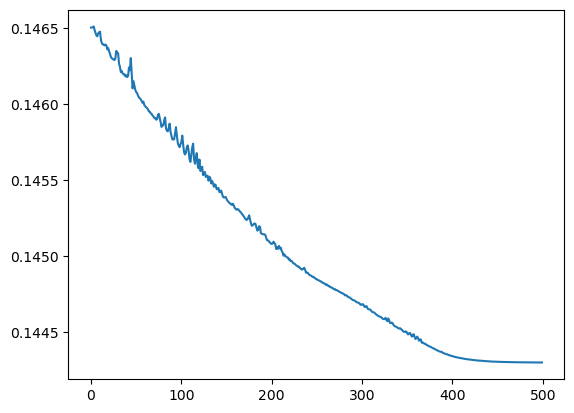

In [103]:
plt.plot(loss_history3a)

In [104]:
accel_pred_nn3 = torch.zeros((2511, 3))
for i in range(len(v)):
    test_v_i = torch.Tensor(v[i]).view(1, -1)
    test_Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
    accel_pred_i = model_3a(test_v_i, test_Rfu_i)
    accel_pred_nn3[i] = accel_pred_i
accel_pred_nn3 = accel_pred_nn3.detach().numpy()

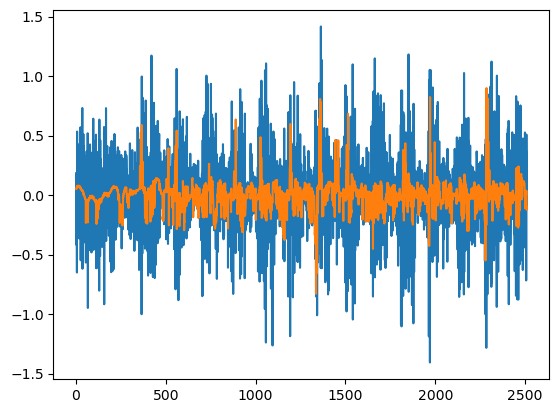

In [330]:
acc3_pred = acc_pred3 + accel_pred_nn3
plt.plot(acc[:,1])
plt.plot(acc3_pred[:,1])

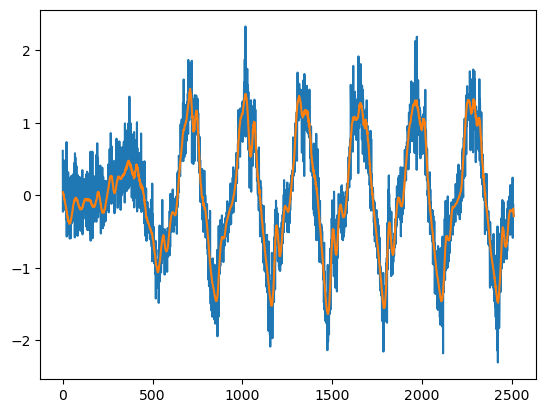

In [332]:
plt.plot(acc[:,0])
plt.plot(acc_pred3[:,0])

In [333]:
mean_squared_error(acc, acc3_pred)

0.14429730028425256

## SINDy basis function sin(x), cos(x), x*y, sin(x)*sin(y) and sin(x*y)

In [111]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.3, alpha=.3)

library_functions = [
    lambda x : np.sin(x),
    lambda x : np.cos(x),
    lambda x,y : x*y,
    lambda x,y : np.sin(x*y)
]
library_function_names = [
    lambda x : '*np.sin(' + x + ')',
    lambda x : '*np.cos(' + x + ')',
    lambda x,y : x + '*' + y,
    lambda x,y : '*np.sin(' + x + '^' + y + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model4 = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model4.fit(v, u=Rfu, t=dt)
model4.print()

(x0)' = -1.087 *np.sin(x0) + 8.568 *np.sin(x1) + 6.590 *np.sin(u0) + -1.056 *np.cos(u0) + -386.368 x0*x1 + -2.785 x0*u2 + -43490.522 x1*u2 + 368.238 x2*u0 + -1356.264 u0*u2 + -7.032 *np.sin(x0)*np.sin(x1) + 2.380 *np.sin(x0)*np.sin(u2) + -205.314 *np.sin(x1)*np.sin(u2) + 3.006 *np.sin(x2)*np.sin(u0) + 295.958 *np.sin(u0)*np.sin(u2) + 392.018 *np.sin(x0^x1) + 2.489 *np.sin(x0^u2) + 43667.907 *np.sin(x1^u2) + -374.374 *np.sin(x2^u0) + 0.554 *np.sin(x2^u2) + 1098.495 *np.sin(u0^u2)
(x1)' = 1.661 *np.sin(u1)
(x2)' = 0.845 *np.sin(x0) + 1.334 *np.sin(x1) + 345.835 *np.sin(u1) + 17.830 *np.sin(u2) + 1.144 *np.cos(x0) + -10.563 *np.cos(u2) + -5205.538 x0*u0 + 21.355 x0*u2 + 0.594 x2*u2 + -23704.230 u0*u2 + -1401151.295 u1*u2 + -1.342 *np.sin(x0)*np.sin(x2) + -49.404 *np.sin(x0)*np.sin(u0) + 7.139 *np.sin(x0)*np.sin(u2) + -1.270 *np.sin(x2)*np.sin(u2) + -557.509 *np.sin(u0)*np.sin(u2) + -9628.018 *np.sin(u1)*np.sin(u2) + 1.162 *np.sin(x0^x2) + 5273.007 *np.sin(x0^u0) + -32.466 *np.sin(x0^u2) +

In [112]:
acc_pred4 = model4.predict(v,u=Rfu)

In [113]:
residual_acc4 = acc - acc_pred4

In [114]:
error_sindy = mean_squared_error(acc,acc_pred4)
error_sindy

0.16022474250226218

In [116]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(256, 79)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(79, 48)
        self.relu8 = nn.ReLU()
        self.linear9 = nn.Linear(48, output_size)
    
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        out = self.relu6(out)
        out = self.linear7(out)
        out = self.relu7(out)
        out = self.linear8(out)
        out = self.relu8(out)
        out = self.linear9(out)
        return out

# Define the training process
model_4 = LinearRegression(6, 3)  # input_size and output_size should be determined based on your data
criterion = nn.MSELoss()
optimizer = optim.Adam(model_4.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5)

loss_history4 = []
num_epochs = 500
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        accel_i = torch.Tensor(residual_acc4[i]).view(1, -1)
        accel_pred_i = model_4(v_i, Rfu_i)

        loss_i = criterion(accel_pred_i, accel_i)
        loss_i.backward()
        loss += loss_i.item()

        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_history4.append(loss)
    scheduler.step(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/500], Loss: 0.1606
Epoch [20/500], Loss: 0.1602
Epoch [30/500], Loss: 0.1599
Epoch [40/500], Loss: 0.1596
Epoch [50/500], Loss: 0.1594
Epoch [60/500], Loss: 0.1593
Epoch [70/500], Loss: 0.1591
Epoch [80/500], Loss: 0.1590
Epoch [90/500], Loss: 0.1590
Epoch [100/500], Loss: 0.1588
Epoch [110/500], Loss: 0.1587
Epoch [120/500], Loss: 0.1587
Epoch [130/500], Loss: 0.1586
Epoch [140/500], Loss: 0.1584
Epoch [150/500], Loss: 0.1588
Epoch [160/500], Loss: 0.1583
Epoch [170/500], Loss: 0.1581
Epoch [180/500], Loss: 0.1577
Epoch [190/500], Loss: 0.1575
Epoch [200/500], Loss: 0.1573
Epoch [210/500], Loss: 0.1567
Epoch [220/500], Loss: 0.1572
Epoch [230/500], Loss: 0.1565
Epoch [240/500], Loss: 0.1562
Epoch [250/500], Loss: 0.1560
Epoch [260/500], Loss: 0.1557
Epoch [270/500], Loss: 0.1559
Epoch [280/500], Loss: 0.1556
Epoch [290/500], Loss: 0.1553
Epoch [300/500], Loss: 0.1552
Epoch [310/500], Loss: 0.1551
Epoch [320/500], Loss: 0.1550
Epoch [330/500], Loss: 0.1549
Epoch [340/500], Lo

In [117]:
checkpoint_4 = {
    'model_state_dict': model_4.state_dict(),
    # Add other components if needed
    'optimizer_state_dict': optimizer.state_dict(),
    # 'epoch': epoch,
}
checkpoint_path4 = "/home/arunabh/Documents/thesis4.pth"  # Update with the desired save path
torch.save(checkpoint_4, checkpoint_path4)

In [118]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(256, 79)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(79, 48)
        self.relu8 = nn.ReLU()
        self.linear9 = nn.Linear(48, output_size)
    
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        out = self.relu6(out)
        out = self.linear7(out)
        out = self.relu7(out)
        out = self.linear8(out)
        out = self.relu8(out)
        out = self.linear9(out)
        return out

# Define the training process
model_4a = LinearRegression(6, 3)  # input_size and output_size should be determined based on your data

checkpoint_4 = torch.load("/home/arunabh/Documents/thesis4.pth")
model_4a.load_state_dict(checkpoint_4['model_state_dict'])

criterion = nn.MSELoss()
optimizer = optim.Adam(model_4a.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5)

optimizer.load_state_dict(checkpoint_4['optimizer_state_dict'])

loss_history4a = []
num_epochs = 500
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        accel_i = torch.Tensor(residual_acc4[i]).view(1, -1)
        accel_pred_i = model_4a(v_i, Rfu_i)

        loss_i = criterion(accel_pred_i, accel_i)
        loss_i.backward()
        loss += loss_i.item()

        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_history4a.append(loss)
    scheduler.step(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/500], Loss: 0.1529
Epoch [20/500], Loss: 0.1532
Epoch [30/500], Loss: 0.1529
Epoch [40/500], Loss: 0.1526
Epoch [50/500], Loss: 0.1524
Epoch [60/500], Loss: 0.1522
Epoch [70/500], Loss: 0.1522
Epoch [80/500], Loss: 0.1520
Epoch [90/500], Loss: 0.1520
Epoch [100/500], Loss: 0.1518
Epoch [110/500], Loss: 0.1517
Epoch [120/500], Loss: 0.1516
Epoch [130/500], Loss: 0.1516
Epoch [140/500], Loss: 0.1515
Epoch [150/500], Loss: 0.1515
Epoch [160/500], Loss: 0.1514
Epoch [170/500], Loss: 0.1513
Epoch [180/500], Loss: 0.1512
Epoch [190/500], Loss: 0.1512
Epoch [200/500], Loss: 0.1511
Epoch [210/500], Loss: 0.1511
Epoch [220/500], Loss: 0.1510
Epoch [230/500], Loss: 0.1509
Epoch [240/500], Loss: 0.1509
Epoch [250/500], Loss: 0.1508
Epoch [260/500], Loss: 0.1508
Epoch [270/500], Loss: 0.1507
Epoch [280/500], Loss: 0.1507
Epoch [290/500], Loss: 0.1506
Epoch [300/500], Loss: 0.1506
Epoch [310/500], Loss: 0.1505
Epoch [320/500], Loss: 0.1505
Epoch [330/500], Loss: 0.1505
Epoch [340/500], Lo

In [119]:
checkpoint_4a = {
    'model_state_dict': model_4a.state_dict(),
    # Add other components if needed
    'optimizer_state_dict': optimizer.state_dict(),
    # 'epoch': epoch,
}
checkpoint_path4a = "/home/arunabh/Documents/thesis4a.pth"  # Update with the desired save path
torch.save(checkpoint_4a, checkpoint_path4a)

In [121]:
loss_history4.extend(loss_history4a)

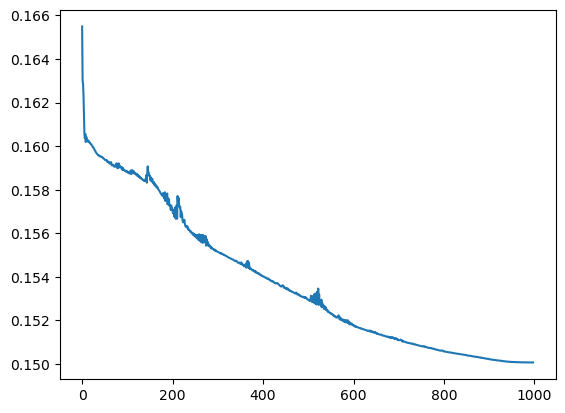

In [124]:
plt.plot(loss_history4[2:])

In [126]:
accel_pred_nn4 = torch.zeros((2511, 3))
for i in range(len(v)):
    test_v_i = torch.Tensor(v[i]).view(1, -1)
    test_Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
    accel_pred_i = model_4a(test_v_i, test_Rfu_i)
    accel_pred_nn4[i] = accel_pred_i
accel_pred_nn4 = accel_pred_nn4.detach().numpy()

In [312]:
mean_squared_error(acc4_pred, acc)

0.1500655663145767

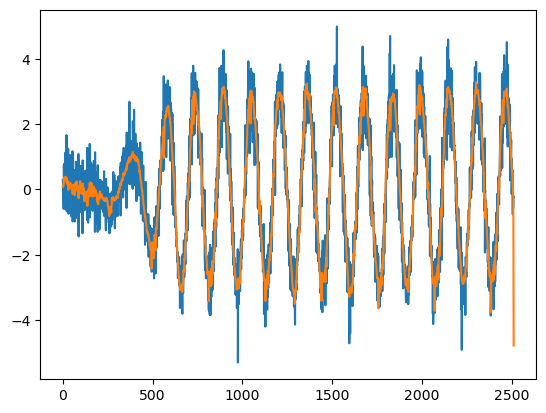

In [316]:
acc4_pred = acc_pred4 + accel_pred_nn4
plt.plot(acc[:,2])
plt.plot(acc4_pred[:,2])

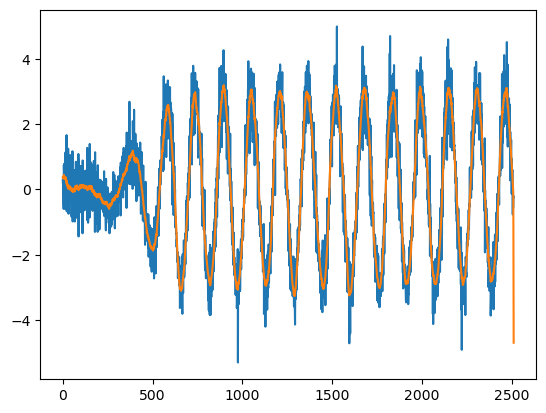

In [315]:
plt.plot(acc[:,2])
plt.plot(acc_pred4[:,2])

## DNN as library function

In [195]:
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
               
        self.fc1 = nn.Linear(1, 50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 100)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(100, 50)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(50, 5)  # Update the output size to 5

    def forward(self, x):
        
        if isinstance(x, np.float64):
            x = torch.tensor([x], dtype=torch.float32)
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(x).float()
        if len(x.shape) != 0:
            x = x.unsqueeze(0).transpose(0, 1)
        #print(x.shape)
        #print('step_0')
        if len(x.shape) == 0:
            x = x.unsqueeze(0)
            
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x.detach().numpy()

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
        
model_DNN = RegressionNN()
model_DNN.apply(init_weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_DNN.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5)

loss_historyDNN = []

dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.1, alpha=.3)

library_functions = [
    lambda x: model_DNN(x)[:, 0],  # Output feature 1
    lambda x: model_DNN(x)[:, 1],  # Output feature 2
    lambda x: model_DNN(x)[:, 2],  # Output feature 3
    lambda x: model_DNN(x)[:, 3],  # Output feature 4
    lambda x: model_DNN(x)[:, 4]   # Output feature 5
]

library_function_names = [
    lambda x : '*model_DNN(' + x + ')[:,0]',
    lambda x : '*model_DNN(' + x + ')[:,1]',
    lambda x : '*model_DNN(' + x + ')[:,2]',
    lambda x : '*model_DNN(' + x + ')[:,3]',
    lambda x : '*model_DNN(' + x + ')[:,4]'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model.fit(v, u=Rfu, t=dt)
model.equations()


/home/arunabh/anaconda3/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


['78497428.289 *model_DNN(x1)[:,0] + 198619.060 *model_DNN(x2)[:,0] + 788181.297 *model_DNN(u0)[:,0] + -99474.555 *model_DNN(x0)[:,1] + 171646.114 *model_DNN(x2)[:,1] + 11808714.816 *model_DNN(u0)[:,1] + 94735336.891 *model_DNN(u1)[:,1] + -212742.468 *model_DNN(x0)[:,2] + -42777320.912 *model_DNN(x1)[:,2] + 143442.905 *model_DNN(x2)[:,2] + 223127.165 *model_DNN(x0)[:,3] + 31827920.680 *model_DNN(x1)[:,3] + -133960.149 *model_DNN(x2)[:,3] + 10511921.439 *model_DNN(u0)[:,3] + -99523766.828 *model_DNN(u1)[:,3] + 191004.824 *model_DNN(x0)[:,4] + 44304622.867 *model_DNN(x1)[:,4] + 24555825.725 *model_DNN(u0)[:,4] + -40535396.755 *model_DNN(u1)[:,4]',
 '0.000',
 '-2706021.498 *model_DNN(x0)[:,0] + 186832601.936 *model_DNN(x1)[:,0] + 349820.000 *model_DNN(x2)[:,0] + 6552743.805 *model_DNN(u2)[:,0] + -900819.839 *model_DNN(x0)[:,1] + 82234444.141 *model_DNN(x1)[:,1] + 1781141.340 *model_DNN(x2)[:,1] + -18539301.640 *model_DNN(u0)[:,1] + -291214712.973 *model_DNN(u1)[:,1] + -6572409.686 *model_

In [307]:
# Assuming you have the coefficients stored in separate lists as `coefficients_list`
coefficients_list = model.coefficients()
# Assuming you have the coefficients stored in separate lists as `coefficients_list`
index = 0
# Define the variable replacements
variable_replacements = {
    'x0': [f'model_DNN(v[{index}][0])[:,0]', f'model_DNN(v[{index}][0])[:,1]', f'model_DNN(v[{index}][0])[:,2]', f'model_DNN(v[{index}][0])[:,3]', f'model_DNN(v[{index}][0])[:,4]'],
    'x1': [f'model_DNN(v[{index}][1])[:,0]', f'model_DNN(v[{index}][1])[:,1]', f'model_DNN(v[{index}][1])[:,2]', f'model_DNN(v[{index}][1])[:,3]', f'model_DNN(v[{index}][1])[:,4]'],
    'x2': [f'model_DNN(v[{index}][2])[:,0]', f'model_DNN(v[{index}][2])[:,1]', f'model_DNN(v[{index}][2])[:,2]', f'model_DNN(v[{index}][2])[:,3]', f'model_DNN(v[{index}][2])[:,4]'],
    'u0': [f'model_DNN(Rfu[{index}][0])[:,0]', f'model_DNN(Rfu[{index}][0])[:,1]', f'model_DNN(Rfu[{index}][0])[:,2]', f'model_DNN(Rfu[{index}][0])[:,3]', f'model_DNN(Rfu[{index}][0])[:,4]'],
    'u1': [f'model_DNN(Rfu[{index}][1])[:,0]', f'model_DNN(Rfu[{index}][1])[:,1]', f'model_DNN(Rfu[{index}][1])[:,2]', f'model_DNN(Rfu[{index}][1])[:,3]', f'model_DNN(Rfu[{index}][1])[:,4]'],
    'u2': [f'model_DNN(Rfu[{index}][2])[:,0]', f'model_DNN(Rfu[{index}][2])[:,1]', f'model_DNN(Rfu[{index}][2])[:,2]', f'model_DNN(Rfu[{index}][2])[:,3]', f'model_DNN(Rfu[{index}][2])[:,4]']
}

# Create equations for each set of coefficients
equations = []
for i in range(3):
    equation = ''
    for k in range(5):
        for j in range(6):
            coefficient = coefficients_list[i][k*6+j]
            if j < 3:
                variable = variable_replacements[f'x{j}'][k]
            else:
                variable = variable_replacements[f'u{j-3}'][k]
            equation += f'{coefficient} * {variable} + '
    equation = equation[:-3]  # Remove the trailing "+ "
    equations.append(equation)


# Print the equations
for i, equation in enumerate(equations):
    print(f"Equation for Feature {i+1}:")
    print(equation)
    print()

SS

Equation for Feature 1:
-1.902916431427002 * model_DNN(v[0][0])[:,0] + -24.58725929260254 * model_DNN(v[0][1])[:,0] + 3.3198766708374023 * model_DNN(v[0][2])[:,0] + 399.259033203125 * model_DNN(Rfu[0][0])[:,0] + 0.0 * model_DNN(Rfu[0][1])[:,0] + 0.5234377980232239 * model_DNN(Rfu[0][2])[:,0] + 2.2921862602233887 * model_DNN(v[0][0])[:,1] + 14.700312614440918 * model_DNN(v[0][1])[:,1] + -1.5530271530151367 * model_DNN(v[0][2])[:,1] + -145.7631072998047 * model_DNN(Rfu[0][0])[:,1] + -24.148340225219727 * model_DNN(Rfu[0][1])[:,1] + 4.630848407745361 * model_DNN(Rfu[0][2])[:,1] + 1.6323041915893555 * model_DNN(v[0][0])[:,2] + 7.9031982421875 * model_DNN(v[0][1])[:,2] + -0.6890754699707031 * model_DNN(v[0][2])[:,2] + -46.524330139160156 * model_DNN(Rfu[0][0])[:,2] + -21.82213592529297 * model_DNN(Rfu[0][1])[:,2] + 4.186434268951416 * model_DNN(Rfu[0][2])[:,2] + 0.24541378021240234 * model_DNN(v[0][0])[:,3] + -2.7068374156951904 * model_DNN(v[0][1])[:,3] + 0.5356893539428711 * model_DNN(v[0

In [306]:
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
               
        self.fc1 = nn.Linear(1, 50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 100)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(100, 50)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(50, 5)  # Update the output size to 5

    def forward(self, x):
        
        if isinstance(x, np.float32) or isinstance(x, np.float64):
            x = torch.tensor([x], dtype=torch.float32)
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(x)
        if len(x.shape) != 0:
            x = x.unsqueeze(0).transpose(0, 1)
        #print(x.shape)
        #print('step_0')
        if len(x.shape) == 0:
            x = x.unsqueeze(0)
        #print(x.type)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x.detach().numpy()

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
        
model_DNN = RegressionNN()
model_DNN.apply(init_weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_DNN.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5)

loss_historyDNN = []

dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.1, alpha=.3)

library_functions = [
    lambda x: model_DNN(x)[:, 0],  # Output feature 1
    lambda x: model_DNN(x)[:, 1],  # Output feature 2
    lambda x: model_DNN(x)[:, 2],  # Output feature 3
    lambda x: model_DNN(x)[:, 3],  # Output feature 4
    lambda x: model_DNN(x)[:, 4]   # Output feature 5
]

library_function_names = [
    lambda x : '*model_DNN(' + x + ')[:,0]',
    lambda x : '*model_DNN(' + x + ')[:,1]',
    lambda x : '*model_DNN(' + x + ')[:,2]',
    lambda x : '*model_DNN(' + x + ')[:,3]',
    lambda x : '*model_DNN(' + x + ')[:,4]'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

num_epochs = 500
model = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model.fit(v, u=Rfu, t=dt)
model.print()

for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    
    for i in range(len(v)):
        index = i
        model = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
        
        if not isinstance(v, torch.Tensor):
            v = torch.from_numpy(v).detach()
            Rfu = torch.from_numpy(Rfu).detach()
            
        model.fit(v, u=Rfu, t=dt)
        coefficients_list = model.coefficients()
        
        
        for p in range(3):
            equation = ''
            for k in range(5):
                for j in range(6):
                    coefficient = coefficients_list[p][k*6+j]
                    if j < 3:
                        variable = variable_replacements[f'x{j}'][k]
                    else:
                        variable = variable_replacements[f'u{j-3}'][k]
                    equation += f'{coefficient} * {variable} + '
            equation = equation[:-3]  # Remove the trailing "+ "
            equations.append(equation)
        
        #v_i = torch.Tensor(v[i]).view(1, -1)
        #Rfu_i = torch.Tensor(Rfu[i]).view(1, -1)
        
        accel_pred_i = torch.zeros(3)
        accel_pred_i[0] = torch.from_numpy(eval(equations[0])).float()
        accel_pred_i[1] = torch.from_numpy(eval(equations[1])).float()
        accel_pred_i[2] = torch.from_numpy(eval(equations[2])).float()
        
        #accel_pred_i = torch.from_numpy([eval(equation) for equation in equations]).float()
        
        accel_i = torch.Tensor(acc[i]).view(1, -1)
        #accel_pred_i = model_DNN(v_i, Rfu_i)

        loss_i = criterion(accel_pred_i, accel_i)
    
        loss_i.backward(retain_graph=True)
        loss += loss_i.item()
        
        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_historyDNN.append(loss)
    scheduler.step(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}") 



(x0)' = -1.903 *model_DNN(x0)[:,0] + -24.587 *model_DNN(x1)[:,0] + 3.320 *model_DNN(x2)[:,0] + 399.259 *model_DNN(u0)[:,0] + 0.523 *model_DNN(u2)[:,0] + 2.292 *model_DNN(x0)[:,1] + 14.700 *model_DNN(x1)[:,1] + -1.553 *model_DNN(x2)[:,1] + -145.763 *model_DNN(u0)[:,1] + -24.148 *model_DNN(u1)[:,1] + 4.631 *model_DNN(u2)[:,1] + 1.632 *model_DNN(x0)[:,2] + 7.903 *model_DNN(x1)[:,2] + -0.689 *model_DNN(x2)[:,2] + -46.524 *model_DNN(u0)[:,2] + -21.822 *model_DNN(u1)[:,2] + 4.186 *model_DNN(u2)[:,2] + 0.245 *model_DNN(x0)[:,3] + -2.707 *model_DNN(x1)[:,3] + 0.536 *model_DNN(x2)[:,3] + 79.712 *model_DNN(u0)[:,3] + -10.230 *model_DNN(u1)[:,3] + 1.963 *model_DNN(u2)[:,3] + 1.251 *model_DNN(x0)[:,4] + 5.521 *model_DNN(x1)[:,4] + -23.733 *model_DNN(u0)[:,4] + -17.680 *model_DNN(u1)[:,4] + 3.395 *model_DNN(u2)[:,4]
(x1)' = -4.037 *model_DNN(u1)[:,1] + -3.648 *model_DNN(u1)[:,2] + -2.956 *model_DNN(u1)[:,4]
(x2)' = 16.390 *model_DNN(x0)[:,0] + -0.626 *model_DNN(x1)[:,0] + 15.246 *model_DNN(x2)[:,0]

In [255]:
torch.set_default_dtype(torch.float32)


## SINDy basis sin(x) and cos(x) -- a deep dive

In [13]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.3, alpha=.3)

library_functions = [
    lambda x : np.sin(x),
    lambda x : np.cos(x)
]
library_function_names = [
    lambda x : '*np.sin(' + x + ')',
    lambda x : '*np.cos(' + x + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model2 = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model2.fit(v, u=Rfu, t=dt)
model2.print()

(x0)' = -0.339 *np.sin(x0) + -0.282 *np.sin(x1) + 21.584 *np.sin(u0) + 3.789 *np.sin(u1) + -1.249 *np.cos(u0)
(x1)' = 1.661 *np.sin(u1)
(x2)' = 1.957 *np.sin(x1) + 14.783 *np.sin(u1) + 23.111 *np.sin(u2) + 0.875 *np.cos(x0) + -12.430 *np.cos(u2)


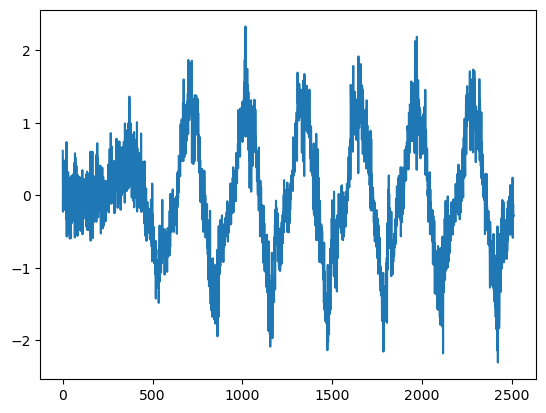

In [14]:
plt.plot(acc[:,0])

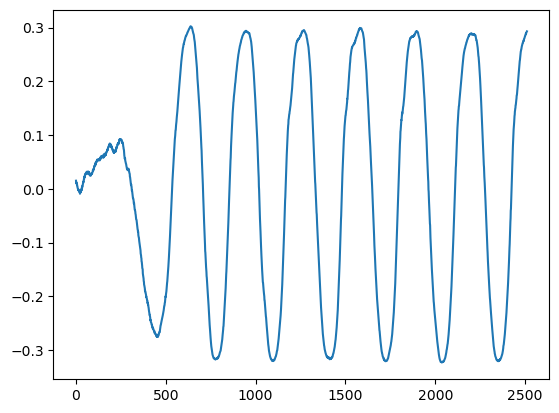

In [18]:
cx1 = -0.339*np.sin(v[:,0])
plt.plot(cx1)

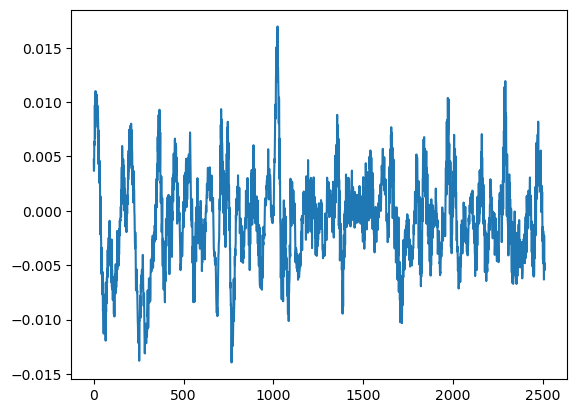

In [21]:
cx2 = -0.282*np.sin(v[:,1])
plt.plot(cx2)

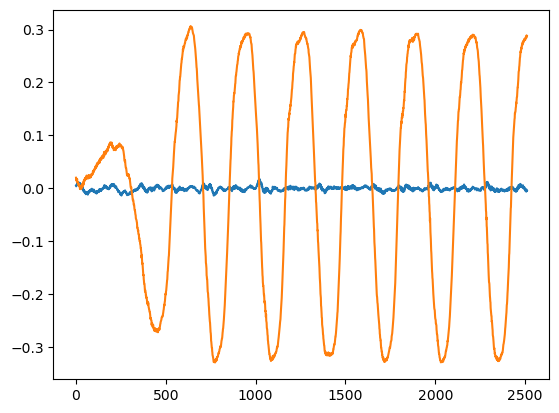

In [23]:
plt.plot(cx2)
plt.plot(cx1+cx2)

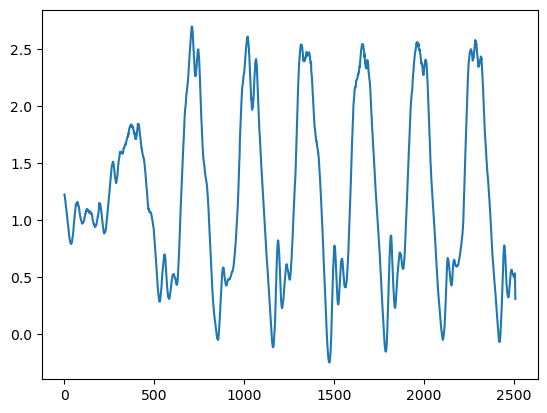

In [24]:
cx3 = 21.584*np.sin(Rfu[:,0])
plt.plot(cx3)

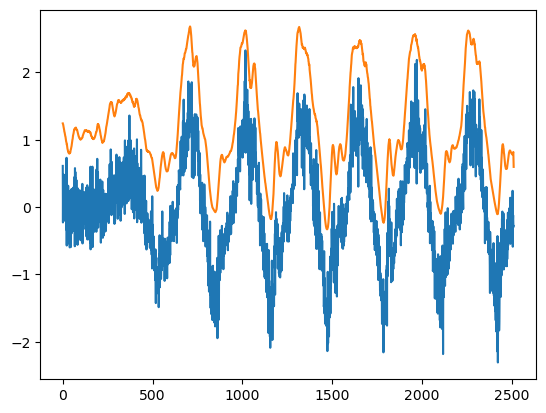

In [25]:
plt.plot(acc[:,0])
plt.plot(cx1 + cx2 + cx3)

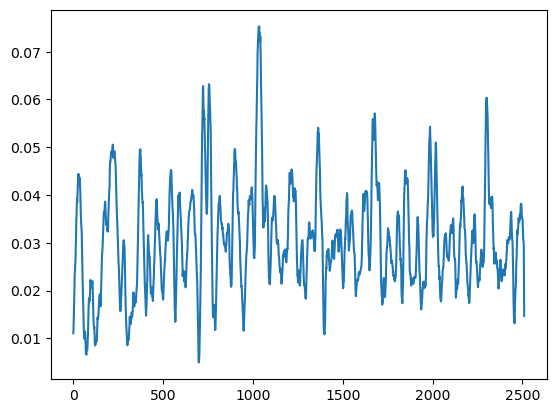

In [31]:
cx4 = 3.789*np.sin(Rfu[:,1])
plt.plot(cx4)

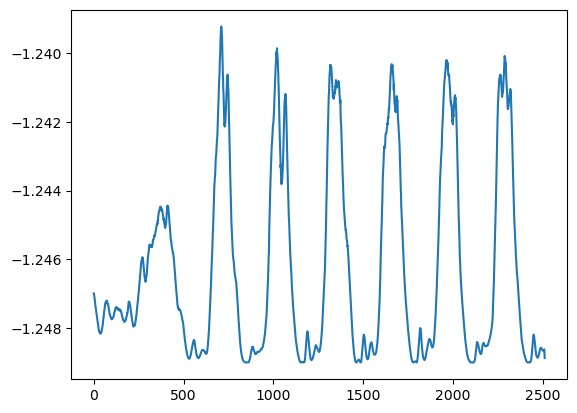

In [32]:
cx5 = -1.249*np.cos(Rfu[:,0])
plt.plot(cx5)

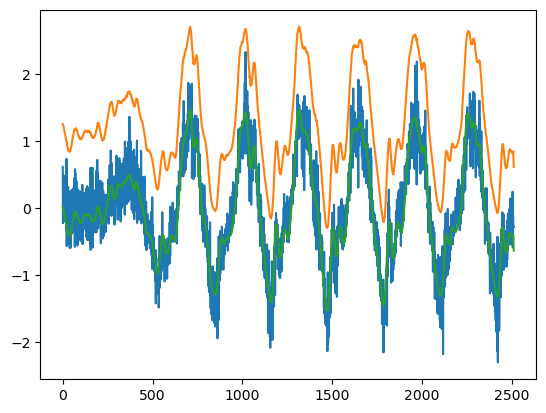

In [35]:
plt.plot(acc[:,0])
plt.plot(cx1+cx2+cx3+cx4)
plt.plot(cx1+cx2+cx3+cx4+cx5)

# Full Dynamics

## SINDy model1

In [40]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.3, alpha=.3)

library_functions = [
    lambda x : np.sin(x),
    lambda x : np.cos(x)
]
library_function_names = [
    lambda x : '*np.sin(' + x + ')',
    lambda x : '*np.cos(' + x + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model.fit(v_n_w, u=control, t=dt)
model.print()

(x0)' = -2.559 *np.sin(x1) + 20.353 *np.sin(u0) + 8.073 *np.sin(u1) + 2.128 *np.sin(u2) + -11.418 *np.sin(u5) + 0.643 *np.cos(x0) + 32.814 *np.cos(u0) + 0.686 *np.cos(u2) + -35.192 *np.cos(u5)
(x1)' = -0.881 *np.sin(x5) + 1.362 *np.sin(u1)
(x2)' = 1.287 *np.sin(x1) + -0.622 *np.sin(x4) + -0.821 *np.sin(x5) + 0.916 *np.sin(u1) + 20.165 *np.sin(u2) + 33.231 *np.sin(u3) + -48.363 *np.sin(u4) + 0.785 *np.sin(u5) + 0.742 *np.cos(x0) + 1.376 *np.cos(x4) + -12.774 *np.cos(u2)
(x3)' = 3.268 *np.sin(x1) + 2.081 *np.sin(x5) + 54.963 *np.sin(u1) + 18.803 *np.sin(u3) + -8.294 *np.sin(u4) + 1.533 *np.sin(u5) + -3.424 *np.cos(x4) + 3.035 *np.cos(u2)
(x4)' = -4.116 *np.sin(x1) + 0.636 *np.sin(x2) + 4.161 *np.sin(x3) + 5.361 *np.sin(x5) + -1.193 *np.sin(u0) + 23.177 *np.sin(u1) + 0.067 *np.sin(u2) + -13.291 *np.sin(u3) + 13.008 *np.sin(u5) + 1.023 *np.cos(x0) + -6.779 *np.cos(x4) + 5.431 *np.cos(u2)
(x5)' = 0.666 *np.sin(x3)


In [41]:
v_n_w_predict = model.predict(v_n_w, u = control)

In [153]:
op_vec = torch.zeros((2511,6))
for i in range(len(v)):
    alpha_i = torch.Tensor(alpha[i]).view(1, -1)
    acc_i = torch.Tensor(acc[i]).view(1, -1)
    op_i = torch.cat((acc_i, alpha_i), dim=-1)
    op_vec[i] = op_i
    
op_vec[2510]

tensor([-0.2862, -0.1082, -0.2183,  0.5730,  0.8822, -0.1429])

In [97]:
sindy_full1_error = mean_squared_error(op_vec, v_n_w_predict)
sindy_full1_error

0.2911122790234986

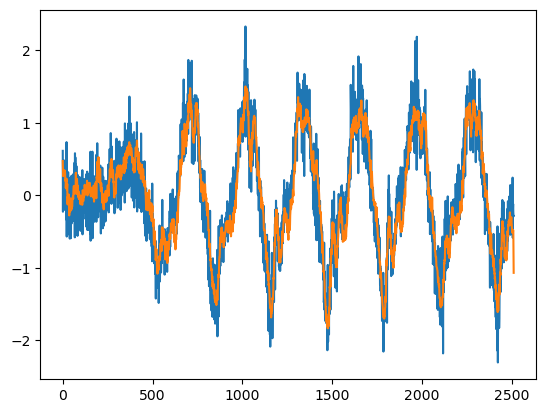

In [42]:
plt.plot(acc[:,0])
plt.plot(v_n_w_predict[:,0])

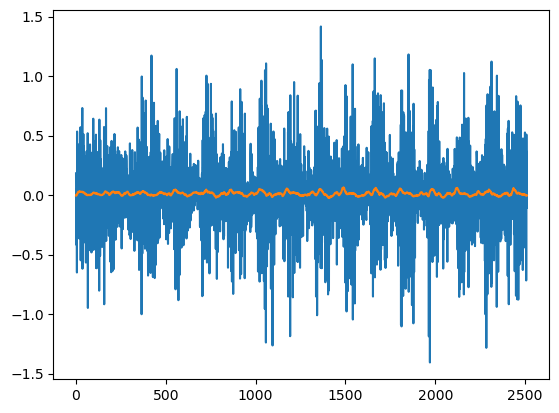

In [43]:
plt.plot(acc[:,1])
plt.plot(v_n_w_predict[:,1])

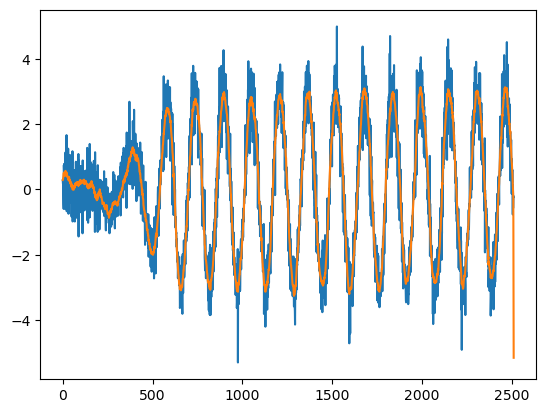

In [44]:
plt.plot(acc[:,2])
plt.plot(v_n_w_predict[:,2])

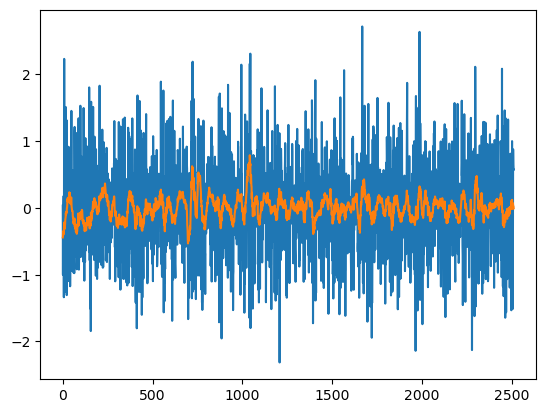

In [45]:
plt.plot(alpha[:,0])
plt.plot(v_n_w_predict[:,3])

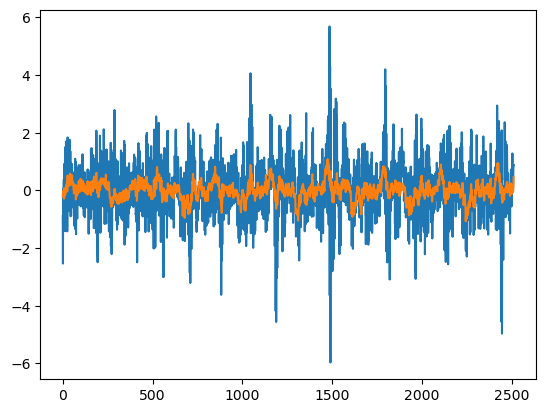

In [46]:
plt.plot(alpha[:,1])
plt.plot(v_n_w_predict[:,4])

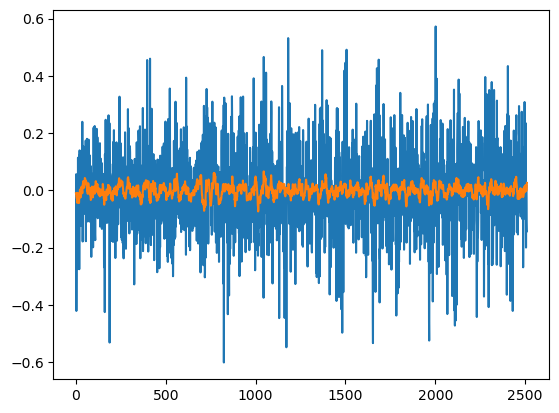

In [47]:
plt.plot(alpha[:,2])
plt.plot(v_n_w_predict[:,5])

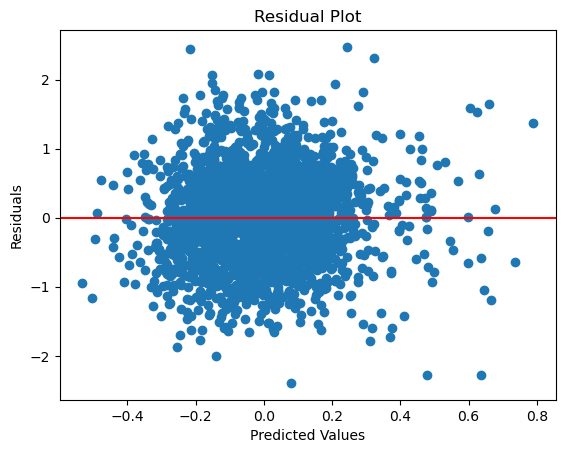

In [48]:
residuals = np.array(alpha[:,0]) - np.array(v_n_w_predict[:,3])

# Plot the residuals against the predicted values
plt.scatter(v_n_w_predict[:,3], residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

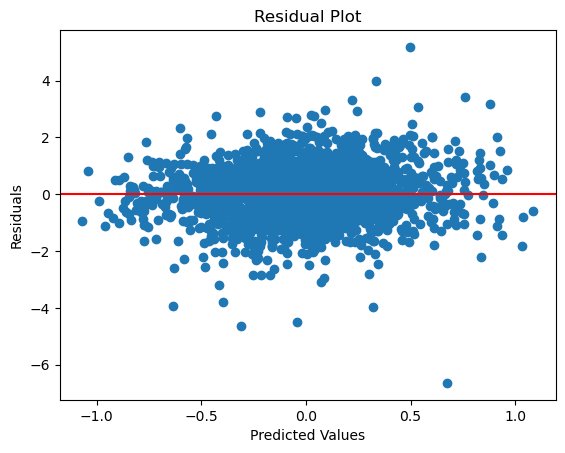

In [49]:
residuals = np.array(alpha[:,1]) - np.array(v_n_w_predict[:,4])

# Plot the residuals against the predicted values
plt.scatter(v_n_w_predict[:,4], residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

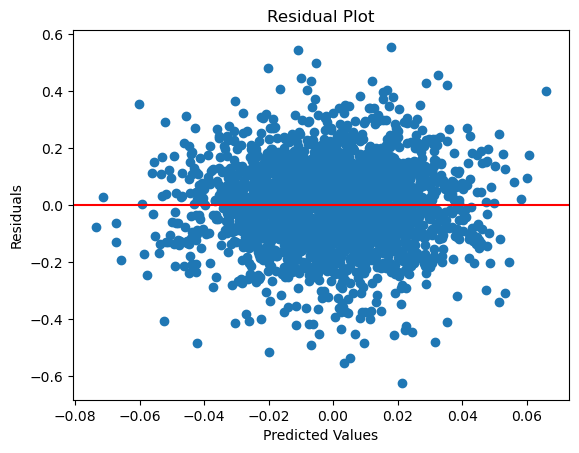

In [50]:
residuals = np.array(alpha[:,2]) - np.array(v_n_w_predict[:,5])

# Plot the residuals against the predicted values
plt.scatter(v_n_w_predict[:,5], residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [118]:
residuals = np.array(alpha) - np.array(v_n_w_predict[:,3:])

0.4156850709415631 0.7939525312004948 0.020563372929793093


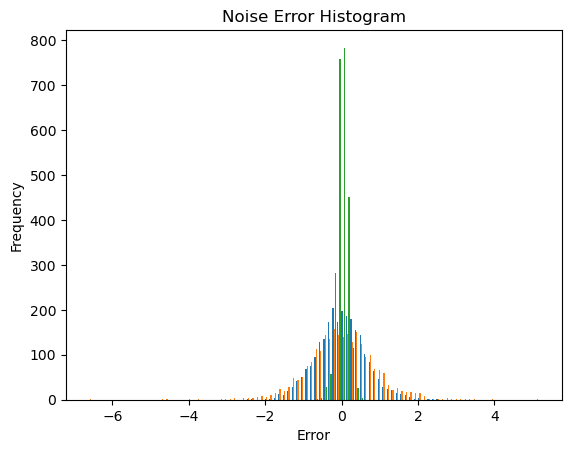

In [120]:
print(np.var(residuals[:,0]),np.var(residuals[:,1]),np.var(residuals[:,2]))
plt.hist(residuals, bins=100)
plt.title('Noise Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

## SINDy Model 2

In [101]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.25, alpha=.3)

library_functions = [
    lambda x : np.sin(x),
    lambda x : np.cos(x),
    lambda x,y : x*y,
    lambda x,y : np.sin(x*y)
]
library_function_names = [
    lambda x : '*np.sin(' + x + ')',
    lambda x : '*np.cos(' + x + ')',
    lambda x,y : x + '*' + y,
    lambda x,y : '*np.sin(' + x + '^' + y + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model2 = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model2.fit(v_n_w, u=control, t=dt)
model2.print()

(x0)' = -0.990 *np.sin(x0) + -0.712 *np.sin(x1) + -0.156 *np.sin(x3) + -0.199 *np.sin(x4) + 1.716 *np.sin(u0) + 2.315 *np.sin(u2) + 5.931 *np.sin(u5) + -5.419 *np.cos(u0) + 4.070 *np.cos(u2) + 2373.989 x0*x1 + -6.250 x0*u2 + -26.281 x0*u5 + -39606.499 x1*u2 + 154.284 x2*u0 + -113.565 x2*u5 + -30.925 x4*u2 + -5593.852 u0*u2 + -143292.089 u0*u5 + 4057.805 u2*u5 + -2373.925 *np.sin(x0^x1) + 7.878 *np.sin(x0^u2) + 25.211 *np.sin(x0^u5) + 39605.722 *np.sin(x1^u2) + -156.379 *np.sin(x2^u0) + 115.513 *np.sin(x2^u5) + 31.193 *np.sin(x4^u2) + 5629.445 *np.sin(u0^u2) + 143318.751 *np.sin(u0^u5) + -4080.586 *np.sin(u2^u5)
(x1)' = -0.881 *np.sin(x5) + 1.362 *np.sin(u1)
(x2)' = 5.127 *np.sin(x1) + 0.131 *np.sin(x3) + 0.170 *np.sin(x4) + 17.300 *np.sin(x5) + 10.410 *np.sin(u1) + 24.126 *np.sin(u2) + 47.446 *np.sin(u3) + -151.537 *np.sin(u4) + 20.738 *np.sin(u5) + -12.140 *np.cos(u2) + -18.643 x0*x4 + 20.619 x0*u0 + -3.077 x0*u2 + 147480.419 x1*u2 + -520.826 x2*x3 + -2.621 x2*u2 + 235.124 x2*u5 + -71

In [103]:
v_n_w_predict2 = model2.predict(v_n_w, u = control)

In [104]:
sindy_full2_error = mean_squared_error(op_vec, v_n_w_predict2)
sindy_full2_error

0.27158099550456105

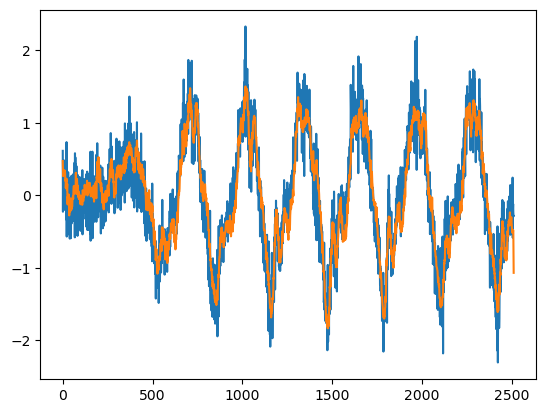

In [105]:
plt.plot(acc[:,0])
plt.plot(v_n_w_predict[:,0])

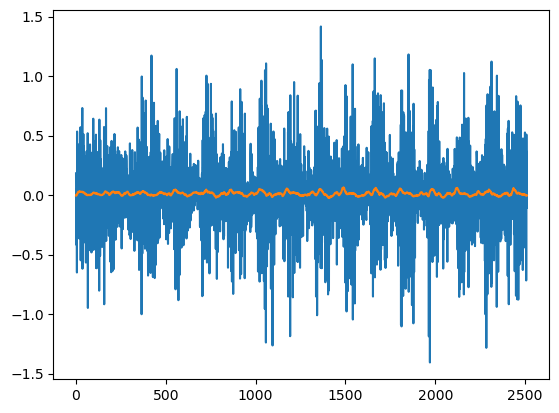

In [106]:
plt.plot(acc[:,1])
plt.plot(v_n_w_predict[:,1])

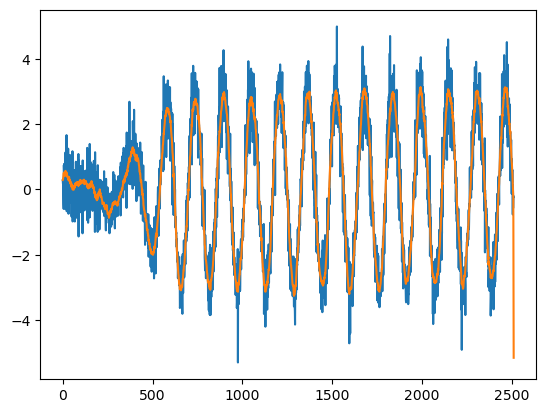

In [107]:
plt.plot(acc[:,2])
plt.plot(v_n_w_predict[:,2])

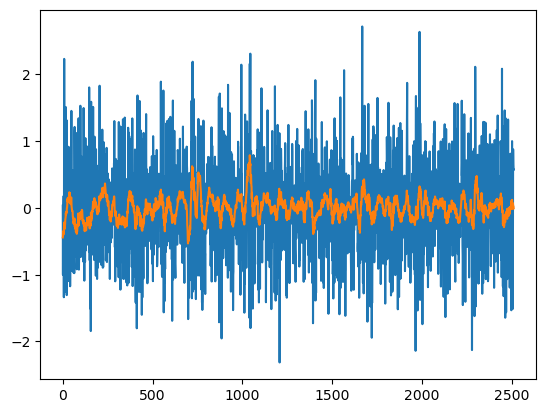

In [108]:
plt.plot(alpha[:,0])
plt.plot(v_n_w_predict[:,3])

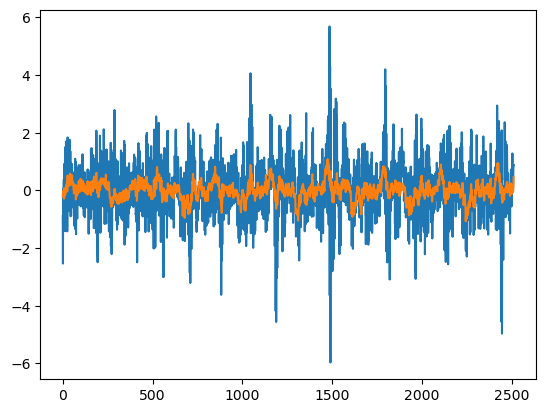

In [109]:
plt.plot(alpha[:,1])
plt.plot(v_n_w_predict[:,4])

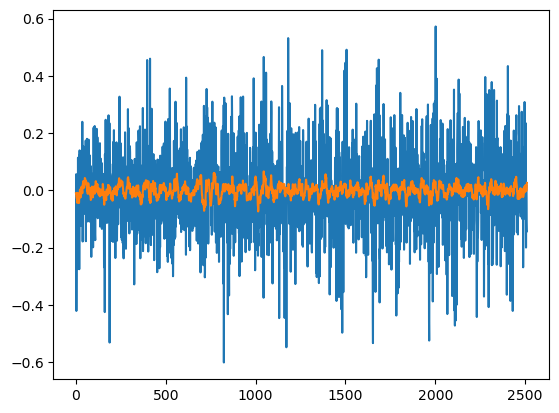

In [110]:
plt.plot(alpha[:,2])
plt.plot(v_n_w_predict[:,5])

## DNN Model 3

In [75]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(256, 79)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(79, 48)
        self.relu8 = nn.ReLU()
        self.linear9 = nn.Linear(48, output_size)
    
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        out = self.relu6(out)
        out = self.linear7(out)
        out = self.relu7(out)
        out = self.linear8(out)
        out = self.relu8(out)
        out = self.linear9(out)
        return out

# Define the training process
model_3 = LinearRegression(12, 6)  # input_size and output_size should be determined based on your data

criterion = nn.MSELoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5)

loss_history = []
num_epochs = 500
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        w_i = torch.Tensor(w[i]).view(1, -1)
        ip_i = torch.cat((v_i, w_i), dim=-1)
        control_i = torch.Tensor(control[i]).view(1, -1)
        alpha_i = torch.Tensor(alpha[i]).view(1, -1)
        acc_i = torch.Tensor(acc[i]).view(1, -1)
        op_i = torch.cat((acc_i, alpha_i), dim=-1)
        pred_i = model_3(ip_i, control_i)

        loss_i = criterion(pred_i, op_i)
        loss_i.backward()
        loss += loss_i.item()

        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_history.append(loss)
    scheduler.step(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/500], Loss: 1.0033
Epoch [20/500], Loss: 0.8827
Epoch [30/500], Loss: 0.8011
Epoch [40/500], Loss: 0.5442
Epoch [50/500], Loss: 0.4365
Epoch [60/500], Loss: 0.4220
Epoch [70/500], Loss: 0.4147
Epoch [80/500], Loss: 0.4097
Epoch [90/500], Loss: 0.4085
Epoch [100/500], Loss: 0.4071
Epoch [110/500], Loss: 0.4061
Epoch [120/500], Loss: 0.4052
Epoch [130/500], Loss: 0.4042
Epoch [140/500], Loss: 0.4020
Epoch [150/500], Loss: 0.3819
Epoch [160/500], Loss: 0.3844
Epoch [170/500], Loss: 0.3686
Epoch [180/500], Loss: 0.3606
Epoch [190/500], Loss: 0.3509
Epoch [200/500], Loss: 0.3522
Epoch [210/500], Loss: 0.3461
Epoch [220/500], Loss: 0.3413
Epoch [230/500], Loss: 0.3365
Epoch [240/500], Loss: 0.3304
Epoch [250/500], Loss: 0.3240
Epoch [260/500], Loss: 0.3205
Epoch [270/500], Loss: 0.3157
Epoch [280/500], Loss: 0.3097
Epoch [290/500], Loss: 0.3000
Epoch [300/500], Loss: 0.2939
Epoch [310/500], Loss: 0.2876
Epoch [320/500], Loss: 0.2845
Epoch [330/500], Loss: 0.2834
Epoch [340/500], Lo

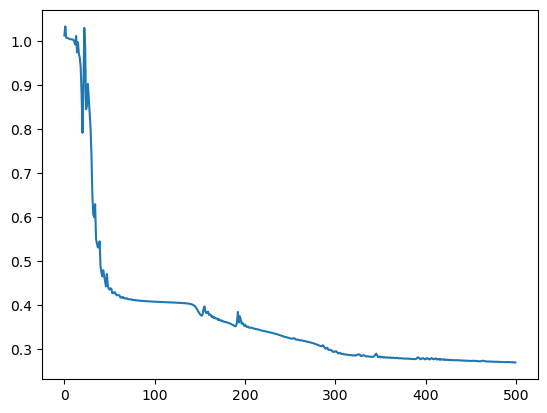

In [76]:
plt.plot(loss_history)

In [77]:
pred_model3 = torch.zeros((2511, 6))
for i in range(len(v)):
    v_i = torch.Tensor(v[i]).view(1, -1)
    w_i = torch.Tensor(w[i]).view(1, -1)
    ip_i = torch.cat((v_i, w_i), dim=-1)
    control_i = torch.Tensor(control[i]).view(1, -1)
    pred_i = model_3(ip_i, control_i)
    pred_model3[i] = pred_i
pred_model3 = pred_model3.detach().numpy()

In [85]:
checkpoint_full1 = {
    'model_state_dict': model_3.state_dict(),
    # Add other components if needed
    'optimizer_state_dict': optimizer.state_dict(),
    # 'epoch': epoch,
}
checkpoint_path_full1 = "/home/arunabh/Documents/thesisfull1.pth"  # Update with the desired save path
torch.save(checkpoint_full1, checkpoint_path_full1)


In [87]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 1024)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(256, 79)
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(79, 48)
        self.relu8 = nn.ReLU()
        self.linear9 = nn.Linear(48, output_size)
    
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        out = self.relu6(out)
        out = self.linear7(out)
        out = self.relu7(out)
        out = self.linear8(out)
        out = self.relu8(out)
        out = self.linear9(out)
        return out

# Define the training process
model_3full1 = LinearRegression(12, 6)  # input_size and output_size should be determined based on your data

checkpoint = torch.load("/home/arunabh/Documents/thesisfull1.pth")
model_3full1.load_state_dict(checkpoint['model_state_dict'])

criterion = nn.MSELoss()
optimizer = optim.Adam(model_3full1.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

loss_historyfull1 = []
num_epochs = 500
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        v_i = torch.Tensor(v[i]).view(1, -1)
        w_i = torch.Tensor(w[i]).view(1, -1)
        ip_i = torch.cat((v_i, w_i), dim=-1)
        control_i = torch.Tensor(control[i]).view(1, -1)
        alpha_i = torch.Tensor(alpha[i]).view(1, -1)
        acc_i = torch.Tensor(acc[i]).view(1, -1)
        op_i = torch.cat((acc_i, alpha_i), dim=-1)
        pred_i = model_3full1(ip_i, control_i)

        loss_i = criterion(pred_i, op_i)
        loss_i.backward()
        loss += loss_i.item()

        
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_historyfull1.append(loss)
    scheduler.step(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/500], Loss: 0.2685
Epoch [20/500], Loss: 0.2682
Epoch [30/500], Loss: 0.2669
Epoch [40/500], Loss: 0.2664
Epoch [50/500], Loss: 0.2657
Epoch [60/500], Loss: 0.2654
Epoch [70/500], Loss: 0.2647
Epoch [80/500], Loss: 0.2641
Epoch [90/500], Loss: 0.2634
Epoch [100/500], Loss: 0.2628
Epoch [110/500], Loss: 0.2624
Epoch [120/500], Loss: 0.2618
Epoch [130/500], Loss: 0.2614
Epoch [140/500], Loss: 0.2606
Epoch [150/500], Loss: 0.2604
Epoch [160/500], Loss: 0.2595
Epoch [170/500], Loss: 0.2591
Epoch [180/500], Loss: 0.2587
Epoch [190/500], Loss: 0.2581
Epoch [200/500], Loss: 0.2578
Epoch [210/500], Loss: 0.2573
Epoch [220/500], Loss: 0.2570
Epoch [230/500], Loss: 0.2567
Epoch [240/500], Loss: 0.2564
Epoch [250/500], Loss: 0.2561
Epoch [260/500], Loss: 0.2561
Epoch [270/500], Loss: 0.2555
Epoch [280/500], Loss: 0.2553
Epoch [290/500], Loss: 0.2549
Epoch [300/500], Loss: 0.2546
Epoch [310/500], Loss: 0.2546
Epoch [320/500], Loss: 0.2541
Epoch [330/500], Loss: 0.2539
Epoch [340/500], Lo

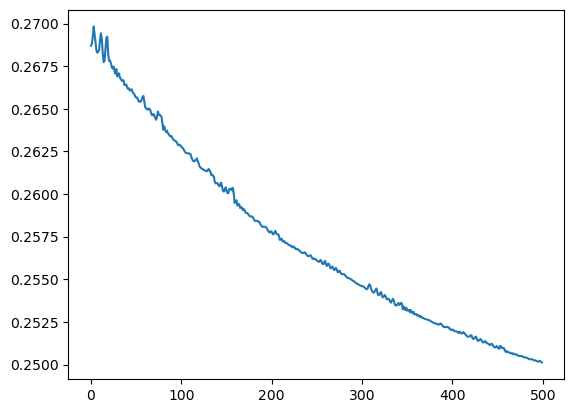

In [111]:
plt.plot(loss_historyfull1)

In [88]:
pred_model3a = torch.zeros((2511, 6))
for i in range(len(v)):
    v_i = torch.Tensor(v[i]).view(1, -1)
    w_i = torch.Tensor(w[i]).view(1, -1)
    ip_i = torch.cat((v_i, w_i), dim=-1)
    control_i = torch.Tensor(control[i]).view(1, -1)
    pred_i = model_3full1(ip_i, control_i)
    pred_model3a[i] = pred_i
pred_model3a = pred_model3a.detach().numpy()

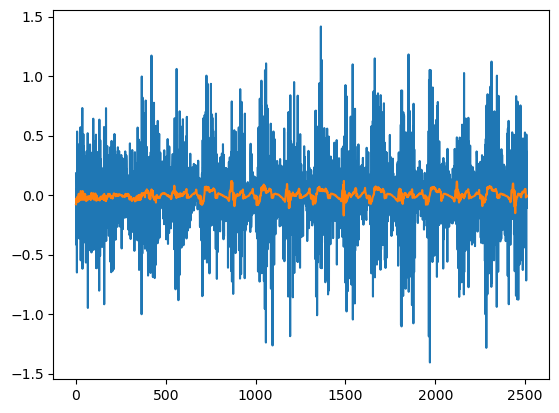

In [117]:
plt.plot(acc[:,1])
plt.plot(pred_model3a[:,1])

In [99]:
dnn_full1_error = mean_squared_error(op_vec, pred_model3a)
dnn_full1_error

0.250089978391697

# Learning the Basis Functions

In [101]:
#Defining the regression basis function

class Regression(nn.Module):
    def __init__(self, input_size, output_size):
        super(Regression, self).__init__()
        self.linear1 = nn.Linear(input_size, 8)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(8, 16)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(16, 24)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(24, 8)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(8, output_size)
    
    def forward(self, sindy_ip):
        out = sindy_ip
        
        if not isinstance(out, torch.Tensor):
            out = torch.tensor(out)
            out = out.unsqueeze(1)
        
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        return out.detach().numpy()

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    
model = Regression(1,2)

model.apply(init_weights)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_historylb = []
num_epochs = 500

#SINDy model using the Regrssion DNN as basis function

dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.1, alpha=.01)

library_functions = [
    lambda x: model(x)[:, 0],  # Output feature 1
    lambda x: model(x)[:, 1]   # Output feature 2
]
library_function_names = [
    lambda x : '*model(' + x + ')[:,0]',
    lambda x : '*model(' + x + ')[:,1]'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model_sindy = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model_sindy.fit(v, u=Rfu, t=dt)
model_sindy.print()
acc_sindy = model_sindy.predict(v, u=Rfu)

(x0)' = -29.534 *model(x0)[:,0] + -200.614 *model(x1)[:,0] + 20.401 *model(x2)[:,0] + 2133.863 *model(u0)[:,0] + 98.406 *model(u1)[:,0] + -18.974 *model(u2)[:,0] + 50.471 *model(x0)[:,1] + 384.219 *model(x1)[:,1] + -42.075 *model(x2)[:,1] + -4574.955 *model(u0)[:,1] + 40.775 *model(u1)[:,1] + -7.862 *model(u2)[:,1]
(x1)' = -1.218 *model(x0)[:,0] + 63.768 *model(x1)[:,0] + 1.819 *model(x2)[:,0] + 164.549 *model(u1)[:,0] + -2.070 *model(u2)[:,0] + 1.349 *model(x0)[:,1] + -143.660 *model(x1)[:,1] + -3.708 *model(x2)[:,1] + 68.181 *model(u1)[:,1] + -0.858 *model(u2)[:,1]
(x2)' = -48.110 *model(x0)[:,0] + -1268.374 *model(x1)[:,0] + 89.363 *model(x2)[:,0] + 7997.044 *model(u0)[:,0] + 275.379 *model(u1)[:,0] + 64.608 *model(u2)[:,0] + 13.119 *model(x0)[:,1] + 1880.536 *model(x1)[:,1] + -186.380 *model(x2)[:,1] + -19311.718 *model(u0)[:,1] + 114.104 *model(u1)[:,1] + 26.771 *model(u2)[:,1]


In [102]:
v[0]

tensor([-0.0448, -0.0167, -0.0341])

In [103]:
Rfu[0]

tensor([0.0567, 0.0029, 0.4761])

In [124]:
v.requires_grad = True
Rfu.requires_grad = True
class CustomFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp):
        v = inp[:,0:3]
        Rfu = inp[:,3:]
        ctx.save_for_backward(v, Rfu)
        
        model_sindy.fit(v, u=Rfu, t=dt)
        model_sindy.print()
    
        acc_sindy = model_sindy.predict(v, u=Rfu)
        acc_sindy = torch.tensor(acc_sindy, requires_grad=True)  
        ctx.save_for_backward(acc_sindy, v, Rfu)  
        return acc_sindy

    @staticmethod
    def backward(ctx, grad_output):
        acc_sindy, v, Rfu = ctx.saved_tensors  # Retrieve the tensors saved in the forward pass
        
        inp =  torch.cat((v, Rfu), dim = 1)
        parameters = model.parameters()
                
        grads = torch.autograd.grad(loss, parameters, create_graph=True)
        print(grads)
        optimizer.zero_grad()  # Clear the gradients of the regression model first
        for param, grad_param in zip(model.parameters(), grads):
            #param.grad = grad_param
            print(param)
        
        return grads

# Custom module that uses the custom autograd function
class CustomModule(nn.Module):
    def forward(self, v, Rfu):
        inp = torch.cat((v, Rfu), dim = 1)
        return CustomFunction.apply(inp)

# Updated Regression model with CustomSquareModule
class Regression(nn.Module):
    def __init__(self, input_size, output_size):
        super(Regression, self).__init__()
        self.linear1 = nn.Linear(input_size, 8)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(8, 16)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(16, 24)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(24, 8)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(8, output_size)
        # may need a change ----------------------------------------------------------------------------------------------
        
    def forward(self, sindy_ip):
        out = sindy_ip

        if not isinstance(out, torch.Tensor):
            out = torch.tensor(out, requires_grad = True)
            out = out.unsqueeze(1)

        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        return out

model = Regression(1,2)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

loss_historylb = []
num_epochs = 500

#SINDy model using the Regrssion DNN as basis function

dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.1, alpha=.01)

library_functions = [
    lambda x: model(x)[:, 0],  # Output feature 1
    lambda x: model(x)[:, 1]   # Output feature 2
]
library_function_names = [
    lambda x : '*model(' + x + ')[:,0]',
    lambda x : '*model(' + x + ')[:,1]'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model_sindy = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
acc_sindy = CustomModule().forward(v, Rfu)
loss = criterion(acc, acc_sindy)

loss.backward()

(x0)' = 62.309 *model(x0)[:,0] + 11360.188 *model(x1)[:,0] + 14.764 *model(x2)[:,0] + 10527.070 *model(u0)[:,0] + -8668.196 *model(u1)[:,0] + 563.984 *model(u2)[:,0] + -66.249 *model(x0)[:,1] + -8172.837 *model(x1)[:,1] + -3988.931 *model(u0)[:,1] + 7527.665 *model(u1)[:,1] + -212.673 *model(u2)[:,1]
(x1)' = 0.746 *model(x0)[:,0] + 7892.970 *model(x1)[:,0] + 1.138 *model(x2)[:,0] + -0.923 *model(x0)[:,1] + -5523.641 *model(x1)[:,1] + -37.089 *model(u0)[:,1] + 2777.130 *model(u1)[:,1] + -17.444 *model(u2)[:,1]
(x2)' = 65.965 *model(x0)[:,0] + 20553.049 *model(x1)[:,0] + 32.139 *model(x2)[:,0] + -118566.509 *model(u0)[:,0] + 112937.240 *model(u1)[:,0] + 63.462 *model(u2)[:,0] + -30.844 *model(x0)[:,1] + -14449.226 *model(x1)[:,1] + -33.454 *model(x2)[:,1] + 88651.016 *model(u0)[:,1] + -83942.075 *model(u1)[:,1] + 4494.626 *model(u2)[:,1]


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [118]:
x = torch.Tensor([[[3.0,4.0,5.0],[1.0,8.0,9.0],[2.0,2.5,9.7]],[[3.0,4.0,5.0],[1.0,8.0,9.0],[2.0,2.5,9.7]]])
x.requires_grad = True
z = x**2
y = torch.sum(z)
res = torch.autograd.grad(y, x)
res

(tensor([[[ 6.0000,  8.0000, 10.0000],
          [ 2.0000, 16.0000, 18.0000],
          [ 4.0000,  5.0000, 19.4000]],
 
         [[ 6.0000,  8.0000, 10.0000],
          [ 2.0000, 16.0000, 18.0000],
          [ 4.0000,  5.0000, 19.4000]]]),)

In [130]:
# torch.autograd.grad(outputs, input) would not work if there is no explicit functional relation between outputs and input
# vjp takes the vector jacobian product but it also needs a functional relation entirely in tensors

In [43]:
# in backward pass need not pass through sindy coeffs
# forward_pass --> input(v, RFu) --> SINDy_model(basis_function(pytorch regression model)) --> acc_sindy --> loss

In [44]:
# backward_pass --> loss --> acc_sindy --> regression model params --> input(v and Rfu) # to bypass the SINDy here as its
# coefficients cant be updated through optimizer.step and it would eventually change totally in the forward pass

## Full Dynamics SINDy model using linear function ( u = control )

In [154]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.25, alpha=.3)

library_functions = [
    lambda x : x
]
library_function_names = [
    lambda x :  x 
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model_lin = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model_lin.fit(v_n_w, u=control, t=dt)
model_lin.print()

(x0)' = -3.756 x1 + 0.715 x4 + 3.206 x5 + 19.778 u0 + -3.062 u2 + 53.437 u3 + -66.765 u4 + -3.179 u5
(x1)' = -0.881 x5 + 1.362 u1
(x2)' = 0.191 x0 + -21.622 x1 + -0.057 x2 + 6.460 x3 + -0.923 x4 + 30.334 x5 + 7.318 u0 + -163.612 u1 + -12.070 u2 + 524.366 u3 + -622.676 u4 + 14.015 u5
(x3)' = -2.788 x5 + 27.867 u1 + -4.421 u3 + 32.020 u4
(x4)' = -5.077 x1 + 4.314 x3 + 6.439 x5 + -4.857 u0 + 10.166 u1 + -7.107 u3 + 3.178 u5
(x5)' = 0.317 x1 + 0.641 x3 + 2.331 u3 + -0.206 u4


In [155]:
result = model_lin.predict(v_n_w, u = control)

In [156]:
print(mean_squared_error(op_vec, result))

0.434680701380682


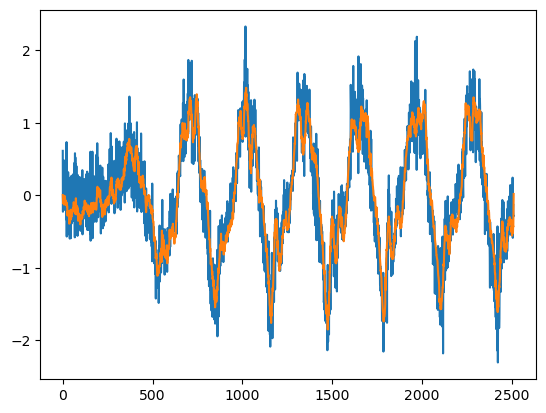

In [105]:
plt.plot(acc[:,0])
plt.plot(result[:,0])

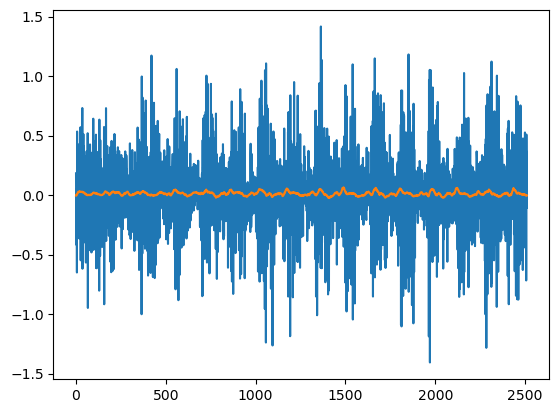

In [106]:
plt.plot(acc[:,1])
plt.plot(result[:,1])

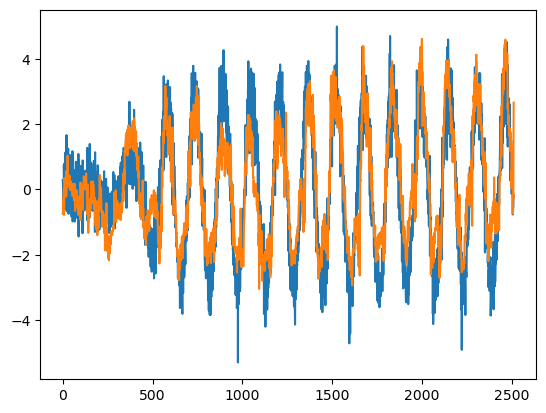

In [107]:
plt.plot(acc[:,2])
plt.plot(result[:,2])

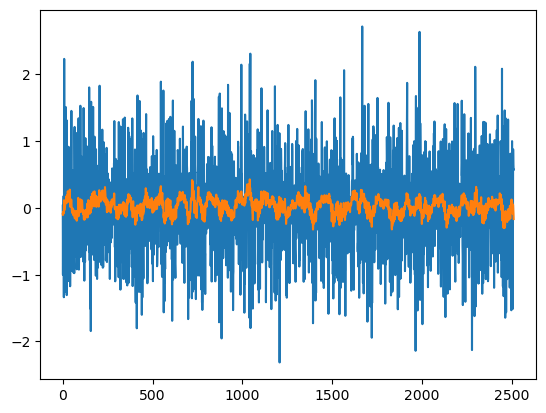

In [108]:
plt.plot(alpha[:,0])
plt.plot(result[:,3])

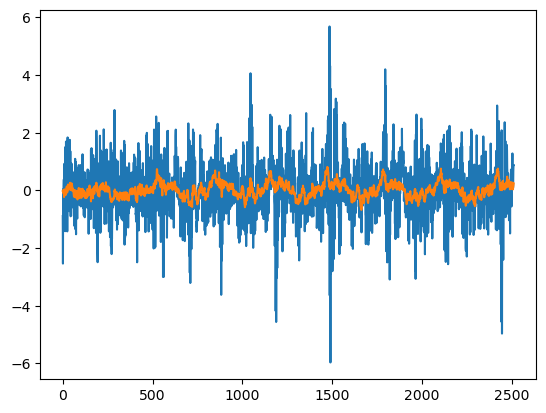

In [109]:
plt.plot(alpha[:,1])
plt.plot(result[:,4])

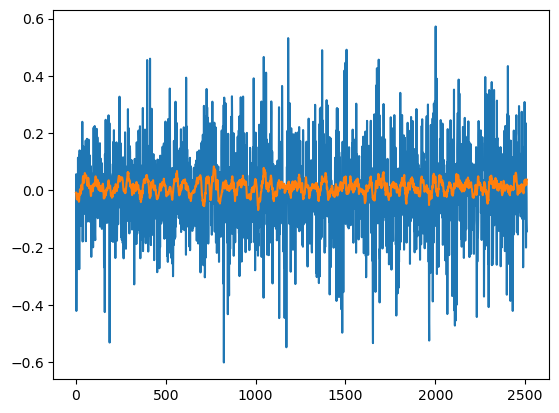

In [110]:
plt.plot(alpha[:,2])
plt.plot(result[:,5])

In [111]:
lin_error = mean_squared_error(alpha,result[:,3:])
lin_error

0.4357197864882705

In [112]:
lin_error = mean_squared_error(acc,result[:,0:3])
lin_error

0.43364161627309356

## Full Dynamics SINDy model using linear function ( u = PWM )

In [157]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.25, alpha=.3)

library_functions = [
    lambda x : x
]
library_function_names = [
    lambda x :  x 
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model_lin2 = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model_lin2.fit(v_n_w, u=pwm, t=dt)
model_lin2.print()

(x0)' = 0.349 x0 + -4.683 x1 + -0.850 x2 + 1.546 x3 + 0.686 x4 + 5.774 x5 + 2.643 u0 + -9.369 u1 + 13.129 u2 + -3.564 u3
(x1)' = -0.612 x5 + 0.857 u0 + 0.779 u1 + -0.752 u2 + -0.930 u3
(x2)' = -17.374 x1 + -0.440 x2 + 7.683 x3 + -3.660 x4 + 15.680 x5 + 66.479 u0 + 57.558 u1 + -59.032 u2 + -68.261 u3
(x3)' = 0.537 x3 + 0.016 x5 + 3.794 u1 + -0.662 u2 + -3.347 u3
(x4)' = -7.634 x1 + 0.338 x2 + 4.804 x3 + 0.325 x5 + -1.667 u0 + 3.657 u1 + -4.063 u2 + 1.104 u3
(x5)' = 0.814 x1 + 0.459 x3 + 1.758 u0 + 1.306 u1 + -1.542 u2 + -1.608 u3


In [158]:
result = model_lin2.predict(v_n_w, u = pwm)

In [159]:
print(mean_squared_error(op_vec, result))

0.6061450780949623


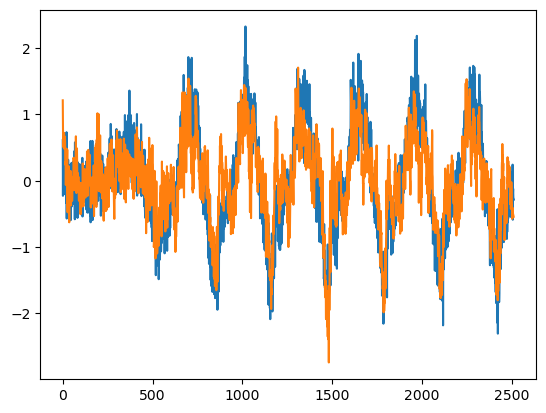

In [115]:
plt.plot(acc[:,0])
plt.plot(result[:,0])

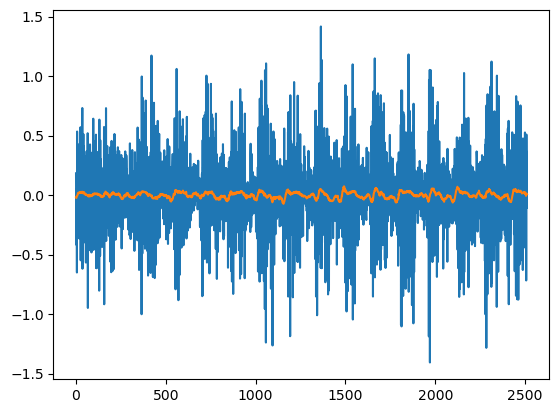

In [116]:
plt.plot(acc[:,1])
plt.plot(result[:,1])

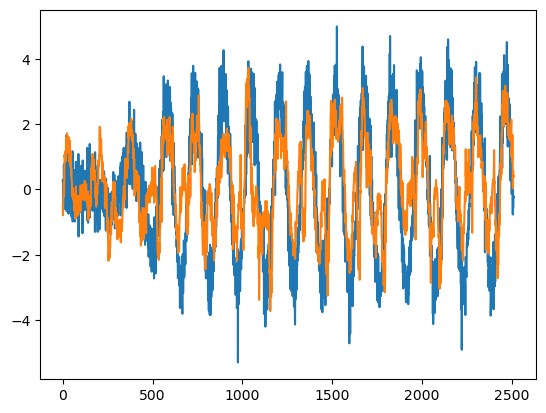

In [117]:
plt.plot(acc[:,2])
plt.plot(result[:,2])

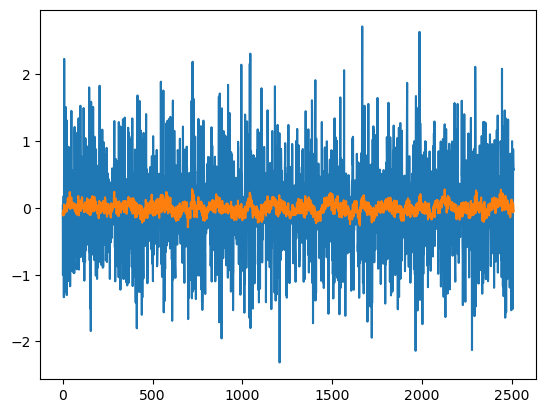

In [118]:
plt.plot(alpha[:,0])
plt.plot(result[:,3])

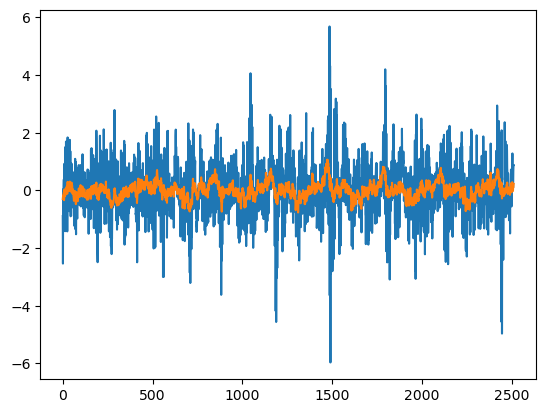

In [119]:
plt.plot(alpha[:,1])
plt.plot(result[:,4])

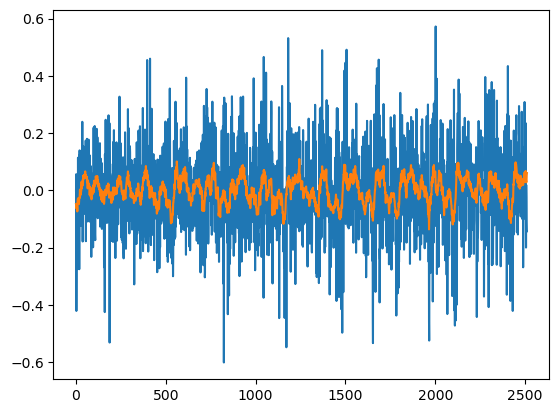

In [120]:
plt.plot(alpha[:,2])
plt.plot(result[:,5])

In [121]:
lin_error2 = mean_squared_error(alpha,result[:,3:])
lin_error2

0.4254128801128018

In [122]:
lin_error2 = mean_squared_error(acc,result[:,0:3])
lin_error2

0.786877276077123

## Full Dynamics SINDy model using sin and cos function ( u = PWM )


In [160]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.25, alpha=.3)

library_functions = [
    lambda x : np.sin(x),
    lambda x : np.cos(x)
]
library_function_names = [
    lambda x : '*np.sin(' + x + ')',
    lambda x : '*np.cos(' + x + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model_pwm = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model_pwm.fit(v_n_w, u=pwm, t=dt)
model_pwm.print()

(x0)' = 0.550 *np.sin(x0) + -2.951 *np.sin(x1) + -0.561 *np.sin(x2) + 1.128 *np.sin(x4) + 1.785 *np.sin(x5) + 12.331 *np.sin(u0) + -18.746 *np.sin(u1) + 4.624 *np.sin(u2) + -17.539 *np.sin(u3) + 1.848 *np.cos(x0) + -396.199 *np.cos(x1) + -0.879 *np.cos(x2) + -57.690 *np.cos(x3) + -4.314 *np.cos(x4) + 482.771 *np.cos(x5) + 8.719 *np.cos(u0) + 2.482 *np.cos(u1) + -14.477 *np.cos(u2) + -8.845 *np.cos(u3)
(x1)' = -1.024 *np.sin(x5)
(x2)' = 1.596 *np.sin(x1) + -0.522 *np.sin(x4) + -0.533 *np.sin(x5) + -7.487 *np.sin(u0) + -17.039 *np.sin(u1) + 14.630 *np.sin(u2) + 15.969 *np.sin(u3) + 1.112 *np.cos(x0) + -0.809 *np.cos(x1) + 20.927 *np.cos(x3) + -0.525 *np.cos(x4) + -21.414 *np.cos(x5) + -14.075 *np.cos(u0) + -17.212 *np.cos(u1) + 14.712 *np.cos(u2) + 7.748 *np.cos(u3)
(x3)' = 0.839 *np.sin(x3) + -0.435 *np.sin(x4) + 2.074 *np.sin(x5) + -2.203 *np.sin(u0) + -4.293 *np.sin(u1) + 5.383 *np.sin(u2) + 2.442 *np.sin(u3) + -3.324 *np.cos(x4) + -5.349 *np.cos(u0) + -9.321 *np.cos(u1) + 9.533 *np.c

In [161]:
result_pwm = model_pwm.predict(v_n_w, u = pwm)

In [162]:
print(mean_squared_error(op_vec, result_pwm))

0.3173709816089342


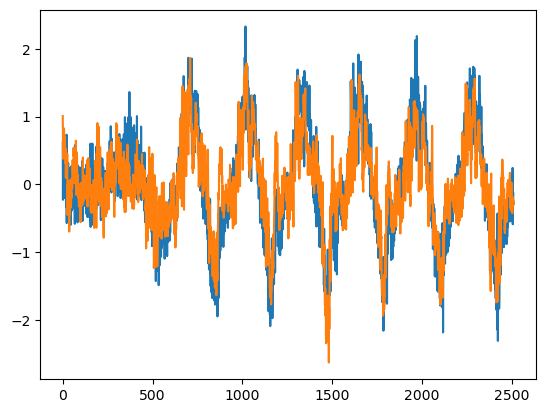

In [125]:
plt.plot(acc[:,0])
plt.plot(result_pwm[:,0])

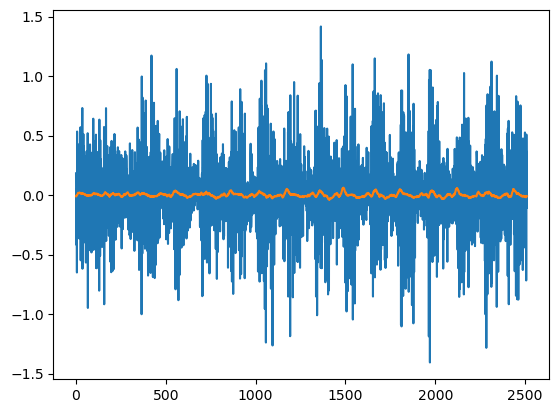

In [126]:
plt.plot(acc[:,1])
plt.plot(result_pwm[:,1])

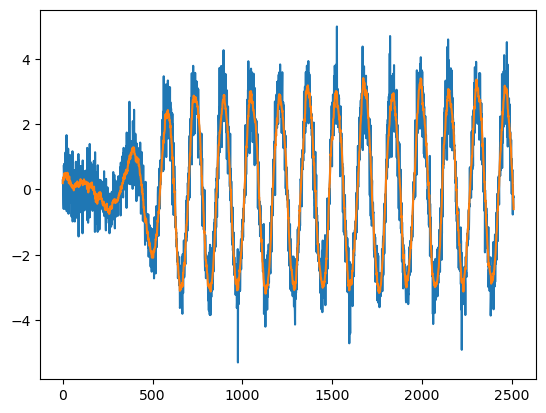

In [127]:
plt.plot(acc[:,2])
plt.plot(result_pwm[:,2])

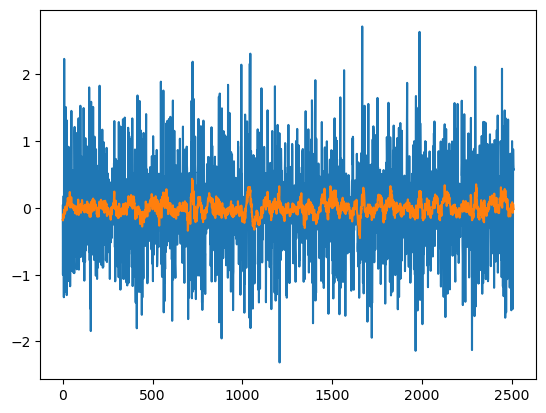

In [128]:
plt.plot(alpha[:,0])
plt.plot(result_pwm[:,3])

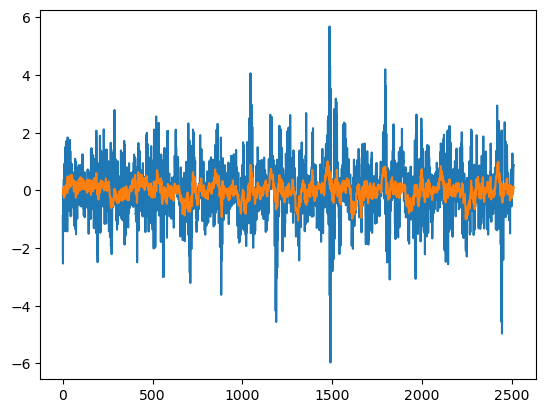

In [129]:
plt.plot(alpha[:,1])
plt.plot(result_pwm[:,4])

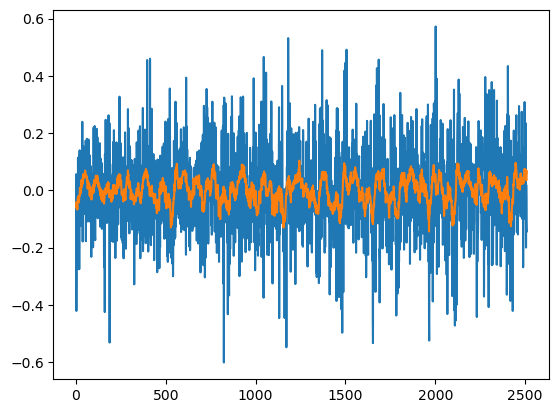

In [130]:
plt.plot(alpha[:,2])
plt.plot(result_pwm[:,5])

In [131]:
pwm_error = mean_squared_error(alpha,result_pwm[:,3:])
pwm_error

0.41394526541616666

In [132]:
pwm_error = mean_squared_error(acc,result_pwm[:,0:3])
pwm_error

0.22079669780170166

## Full Dynamics SINDy model using sin function ( u = PWM )


In [163]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.25, alpha=.3)

library_functions = [
    lambda x : np.sin(x)
]
library_function_names = [
    lambda x : '*np.sin(' + x + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model_pwm2 = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model_pwm2.fit(v_n_w, u=pwm, t=dt)
model_pwm2.print()

(x0)' = 0.442 *np.sin(x0) + -3.060 *np.sin(x1) + -0.973 *np.sin(x2) + 1.497 *np.sin(x4) + 15.061 *np.sin(x5) + 3.352 *np.sin(u0) + -12.173 *np.sin(u1) + 14.673 *np.sin(u2) + -3.676 *np.sin(u3)
(x1)' = -1.024 *np.sin(x5)
(x2)' = -6.621 *np.sin(x1) + -0.449 *np.sin(x2) + 6.080 *np.sin(x3) + -4.091 *np.sin(x4) + -61.223 *np.sin(x5) + -18.633 *np.sin(u0) + -57.131 *np.sin(u1) + 50.685 *np.sin(u2) + 30.320 *np.sin(u3)
(x3)' = -1.558 *np.sin(x5) + -0.448 *np.sin(u0) + 6.001 *np.sin(u1) + -5.674 *np.sin(u3)
(x4)' = -6.671 *np.sin(x1) + 0.363 *np.sin(x2) + 4.753 *np.sin(x3) + -5.535 *np.sin(x5) + -8.403 *np.sin(u0) + -3.861 *np.sin(u1) + 2.759 *np.sin(u2) + 9.216 *np.sin(u3)
(x5)' = 0.508 *np.sin(x1) + 0.584 *np.sin(x3) + 0.578 *np.sin(u0) + -0.531 *np.sin(u3)


In [164]:
result_pwm = model_pwm2.predict(v_n_w, u = pwm)

In [165]:
print(mean_squared_error(op_vec, result_pwm))

0.6107188131271296


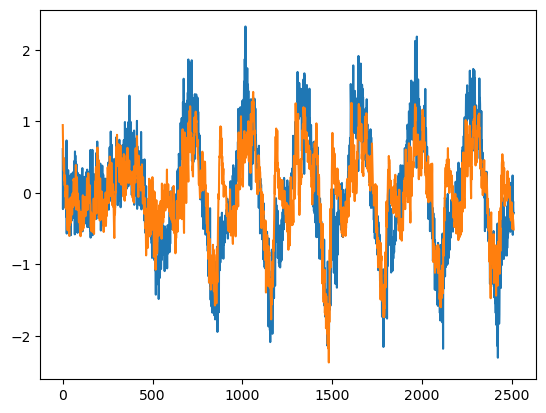

In [135]:
plt.plot(acc[:,0])
plt.plot(result_pwm[:,0])

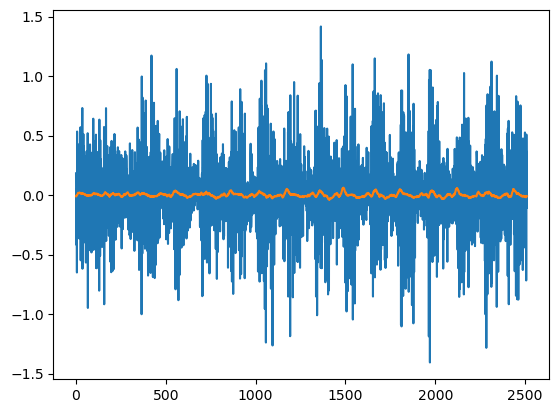

In [136]:
plt.plot(acc[:,1])
plt.plot(result_pwm[:,1])

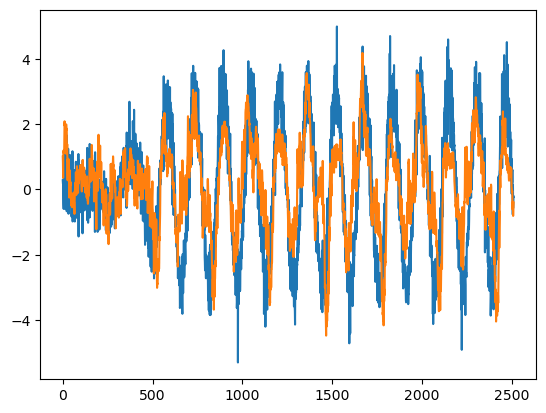

In [137]:
plt.plot(acc[:,2])
plt.plot(result_pwm[:,2])

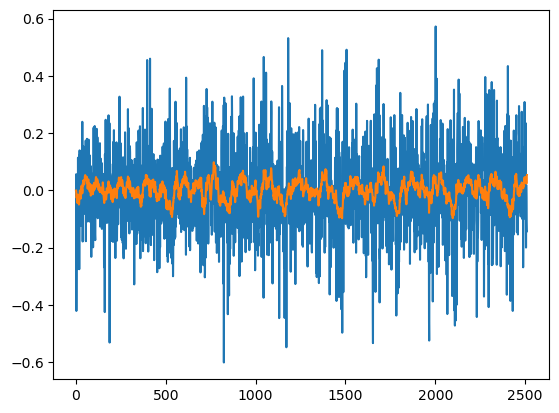

In [138]:
plt.plot(alpha[:,2])
plt.plot(result_pwm[:,5])

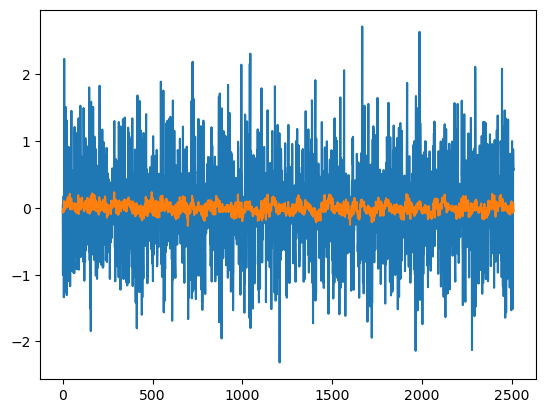

In [139]:
plt.plot(alpha[:,0])
plt.plot(result_pwm[:,3])

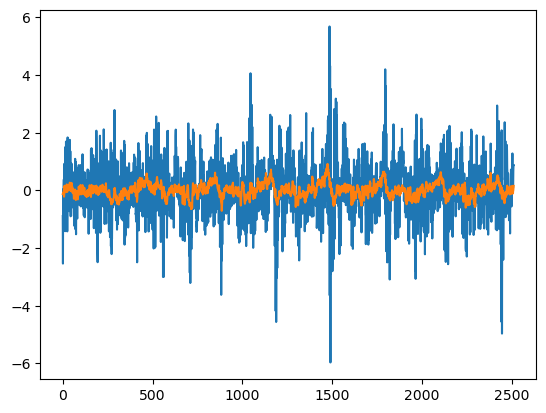

In [140]:
plt.plot(alpha[:,1])
plt.plot(result_pwm[:,4])

In [141]:
pwm_error2 = mean_squared_error(alpha,result_pwm[:,3:])
pwm_error2

0.4390767624024509

In [142]:
pwm_error2 = mean_squared_error(acc,result_pwm[:,0:3])
pwm_error2

0.7823608638518085

## Full Dynamics SINDy model using sin, cos and x function ( u = PWM )


In [166]:
dt = 0.02
stlsq_optimizer = ps.STLSQ(threshold=.25, alpha=.3)

library_functions = [
    lambda x : np.sin(x),
    lambda x : np.cos(x),
    lambda x :  x
]
library_function_names = [
    lambda x : '*np.sin(' + x + ')',
    lambda x : '*np.cos(' + x + ')',
    lambda x : x
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model_pwm3 = ps.SINDy(feature_library=custom_library, optimizer=stlsq_optimizer)
model_pwm3.fit(v_n_w, u=pwm, t=dt)
model_pwm3.print()

(x0)' = 5.173 *np.sin(x0) + 4793.234 *np.sin(x1) + -0.427 *np.sin(x2) + 1.245 *np.sin(x3) + -35288.503 *np.sin(x5) + 28.163 *np.sin(u0) + -31.694 *np.sin(u1) + -138.776 *np.sin(u2) + -109.704 *np.sin(u3) + -372.868 *np.cos(x1) + -0.498 *np.cos(x2) + -66.653 *np.cos(x3) + -7.931 *np.cos(x4) + 71.755 *np.cos(u1) + 149.641 *np.cos(u2) + 157.961 *np.cos(u3) + -4.073 x0 + -4793.250 x1 + -0.414 x2 + 0.274 x4 + 35286.048 x5 + -16.586 u0 + 66.957 u1 + 217.439 u2 + 189.855 u3
(x1)' = 492.713 *np.sin(x5) + -1.571 *np.sin(u2) + -0.647 *np.cos(u0) + 0.926 *np.cos(u3) + -493.545 x5 + 0.688 u0 + 0.923 u1 + -0.482 u3
(x2)' = -15742.694 *np.sin(x1) + -2345.908 *np.sin(x5) + 77.175 *np.sin(u0) + -5.240 *np.sin(u1) + -15.827 *np.sin(u3) + 1.062 *np.cos(x0) + 48.465 *np.cos(x1) + 26.973 *np.cos(x3) + 0.192 *np.cos(x4) + 0.090 *np.cos(x5) + -95.620 *np.cos(u0) + -14.361 *np.cos(u1) + 33.072 *np.cos(u3) + 15741.983 x1 + -0.384 x4 + 2342.332 x5 + -116.747 u0 + -4.508 u1 + 38.784 u3
(x3)' = -0.438 *np.sin(x4

In [167]:
result_pwm = model_pwm3.predict(v_n_w, u = pwm)

In [168]:
print(mean_squared_error(op_vec, result_pwm))

0.30762351652827774


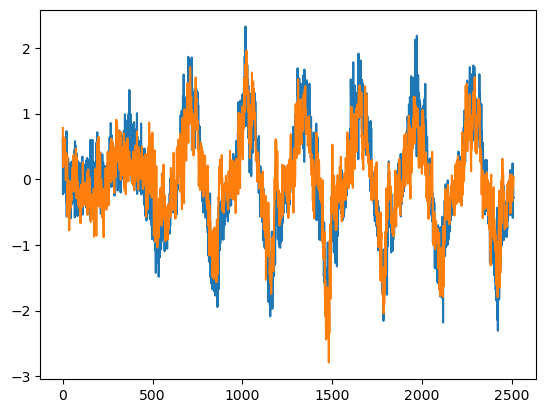

In [145]:
plt.plot(acc[:,0])
plt.plot(result_pwm[:,0])

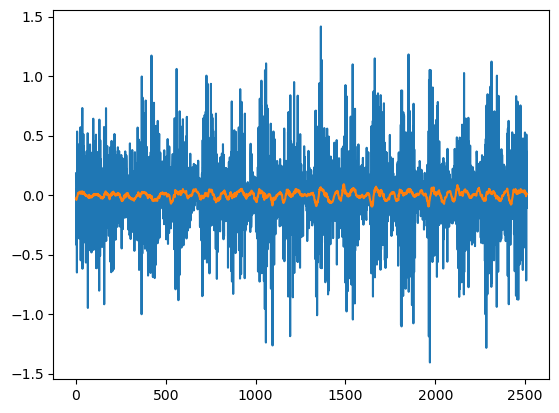

In [146]:
plt.plot(acc[:,1])
plt.plot(result_pwm[:,1])

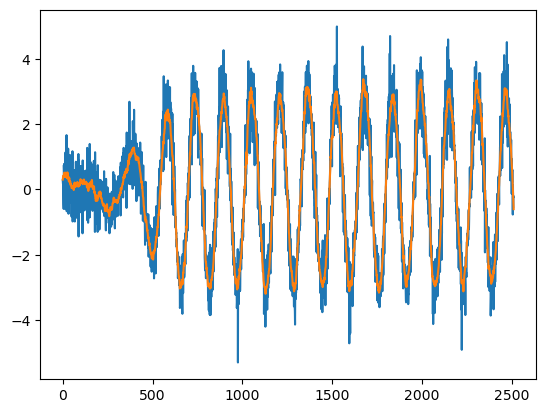

In [147]:
plt.plot(acc[:,2])
plt.plot(result_pwm[:,2])

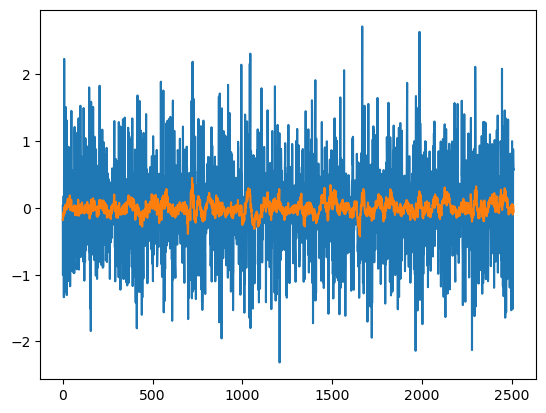

In [148]:
plt.plot(alpha[:,0])
plt.plot(result_pwm[:,3])

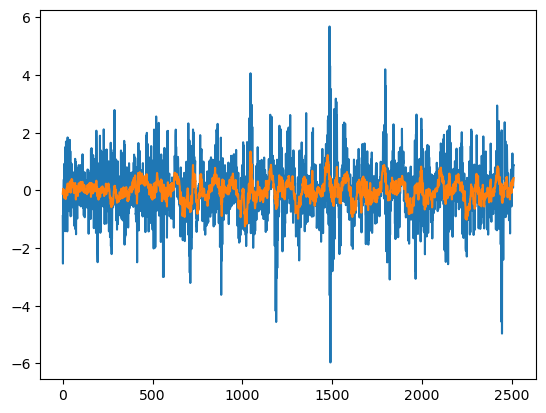

In [149]:
plt.plot(alpha[:,1])
plt.plot(result_pwm[:,4])

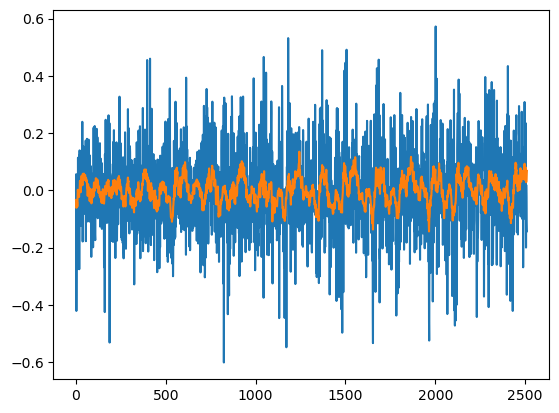

In [150]:
plt.plot(alpha[:,2])
plt.plot(result_pwm[:,5])

In [151]:
pwm_error3 = mean_squared_error(alpha,result_pwm[:,3:])
pwm_error3

0.40420835941281624

In [152]:
pwm_error3 = mean_squared_error(acc,result_pwm[:,0:3])
pwm_error3

0.2110386736437393

## Trying out stuff

In [34]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(2, 4)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(4, 2)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(2, output_size)
       
    def forward(self, v, Rfu):
        out = torch.cat((v, Rfu), dim=1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

# Define the training process
model = LinearRegression(12, 6)  # input_size and output_size should be determined based on your data

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_history = []
num_epochs = 20
for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    for i in range(len(v)):
        #input data
        v_i = torch.Tensor(v[i]).view(1, -1)
        w_i = torch.Tensor(w[i]).view(1, -1)
        ip_i = torch.cat((v_i, w_i), dim=-1)
        control_i = torch.Tensor(control[i]).view(1, -1)
        #making prediction on input data
        pred_i = model(ip_i, control_i)
        #output training labels
        alpha_i = torch.Tensor(alpha[i]).view(1, -1)
        acc_i = torch.Tensor(acc[i]).view(1, -1)
        op_i = torch.cat((acc_i, alpha_i), dim=-1)
        #evaluating the loss
        loss_i = criterion(pred_i, op_i)
        loss_i.backward()
        loss += loss_i.item()
    
    optimizer.step()  # move optimizer step() outside the inner loop
    loss /= len(v)
    loss_history.append(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")

Epoch [10/20], Loss: 1.2132
Epoch [20/20], Loss: 1.1366
